## RMS NORM:

- ⚙️ Why reset_parameters() Exists:
+ When you train massive models (10B–700B+) with FSDP, parameters are often initialized on “meta” devices (no memory allocation) and then materialized later, to save GPU memory during model construction.

- Without a reset_parameters():

  - PyTorch doesn’t know how to populate the parameter tensors once they’re moved from meta to real devices (GPU, CPU).

- This leads to empty or uninitialized weights, causing runtime errors or NaNs.

- So this function defines how the parameters should be re-created deterministically.


In [ ]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Dict, Optional, Tuple, List, Literal

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(dim))
        self.eps = eps
    def reset_parameters(self):
        with torch.no_grad():
            self.weight.fill_(1.0)
    def forward(self, x):
        var = x.pow(2).mean(-1, keepdim=True)
        x = x * torch.rsqrt(var + self.eps)
        return self.weight * x

# simulate fsdp re-init
norm = RMSNorm(4)
norm.weight.data = torch.randn(4) * 5  # corrupted
print(norm.weight)  # corrupted
norm.reset_parameters()
print(norm.weight)  # restored to 1.0


Parameter containing:
tensor([ 3.3694, -5.2268, 14.1812, -1.0962], requires_grad=True)
Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)


It’s the “identity reset button” that keeps large-scale transformer initialization stable and reproducible.


# Swiglu()
- this function lives inside the MLP (feedforward) part of each Transformer block.

- Why CLIP -> Because in massive MoE (Mixture of Experts) or deep LLMs, extreme activations cause instability:
  - Large intermediate activations → gradient explosion

  - Especially harmful in FP16/BF16 training (finite precision)

  - So clipping keeps activations bounded, improving numerical stability.

Essentially, the gate decides "how much" of each corresponding element in up is important and should be allowed to pass through.
+ If a value in silu(gate) is close to zero, the corresponding information in up is suppressed.
+ If it's larger, the information is emphasized and passed on. This gating mechanism allows the model to learn more complex and context-dependent relationships in the data.

In [ ]:
def swiglu(x: torch.Tensor, clip: Optional[float] = None) -> torch.Tensor:
    up, gate = x.chunk(2, dim=-1)
    if clip is not None:
        up = up.clamp(-clip, clip)
        gate = gate.clamp(-clip, clip)
    return F.silu(gate) * up

The input tensor x (which comes from a preceding linear layer) is split into two equal halves along its last dimension.
+ **up**: This is the "up-projection" or the main data pathway. It contains the primary features that the network has learned.
+ **gate**: This tensor acts as a control mechanism or a "gate". It learns to control how much of the information from the up tensor should be passed on to the next layer.

✅ In Short: swiglu() exists because:

- Transformers need a nonlinear gating mechanism in the MLP to model complex dependencies.

- SwiGLU combines smooth activation (SiLU) and multiplicative gating, making it both expressive and stable.

- The clipping prevents numerical overflow in large-scale distributed FP16/BF16 training.

- It’s empirically superior — that’s why PaLM, LLaMA, DeepSeek, and GPT-OSS all use it.

# **RoPE, what “stretch” does:**

Let’s make the **rotation process literally visible** using a toy example, so you can *see* what happens to query (Q) and key (K) vectors as they pass through the RoPE mechanism.

We’ll start with a very small configuration — one batch, one head, 4-dimensional head size (so we have two 2-D “rotation planes”).

---

### 🧩 1. Setup

```python
import torch
import math

# simple parameters
B, T, Dh = 1, 4, 4      # batch=1, 4 tokens, head_dim=4 (two 2D pairs)
theta = 10000.0
factor = 1.0

# positions 0..3
pos = torch.arange(T, dtype=torch.float32)

# build base frequencies
inv_freq = 1.0 / (theta ** (torch.arange(0, Dh, 2).float() / Dh))
print("inv_freq:", inv_freq)
```

Output:

```
inv_freq: tensor([1.0000e+00, 1.0000e-02])
```

That means:

* The first pair (dims 0–1) rotates fast (frequency = 1.0)
* The second pair (dims 2–3) rotates slowly (frequency = 0.01)

---

## ⚙️ 2. Compute cos/sin cache

```python
freqs = torch.einsum("s,f->sf", pos / factor, inv_freq)
cos = torch.cos(freqs)
sin = torch.sin(freqs)

print("cos:\n", cos)
print("sin:\n", sin)
```

Output:

```
cos:
tensor([[1.0000, 1.0000],
        [0.5403, 0.9999],
        [-0.4161, 0.9998],
        [-0.9900, 0.9995]])

sin:
tensor([[0.0000, 0.0000],
        [0.8415, 0.0100],
        [0.9093, 0.0200],
        [0.1411, 0.0300]])
```

Interpretation:

| Position | Fast pair angle (rad) | Slow pair angle |                |
| -------- | --------------------- | --------------- | -------------- |
| 0        | 0                     | 0               | no rotation    |
| 1        | 1 rad ≈ 57°           | 0.01 rad        | small rotation |
| 2        | 2 rad ≈ 114°          | 0.02 rad        |                |
| 3        | 3 rad ≈ 171°          | 0.03 rad        |                |

---

## 🧮 3. Example Q vectors (before rotation)

Let’s define a single query vector per position:

```python
q = torch.tensor([
    [1.0, 0.0,  2.0, 0.0],   # position 0
    [1.0, 0.0,  2.0, 0.0],   # position 1 (same base vector)
    [1.0, 0.0,  2.0, 0.0],
    [1.0, 0.0,  2.0, 0.0],
])
```

Each vector:

```
[ q0_even, q0_odd, q1_even, q1_odd ]
= [1, 0, 2, 0]
```

So initially, both 2-D sub-planes point along the x-axis (no rotation).

---

## 🔄 4. Apply rotation

```python
def apply_rope(x, cos, sin):
    x1, x2 = x[..., ::2], x[..., 1::2]
    xr1 = x1 * cos - x2 * sin
    xr2 = x1 * sin + x2 * cos
    out = torch.empty_like(x)
    out[..., ::2], out[..., 1::2] = xr1, xr2
    return out

q_rot = apply_rope(q, cos, sin)
print(q_rot)
```

Output:

```
tensor([[ 1.0000,  0.0000,  2.0000,  0.0000],
        [ 0.5403,  0.8415,  1.9998,  0.0200],
        [-0.4161,  0.9093,  1.9992,  0.0400],
        [-0.9900,  0.1411,  1.9980,  0.0600]])
```

---

## 🔍 5. Interpret Each Rotation

| Token | Plane 1 (fast dims 0–1) | Plane 2 (slow dims 2–3) | Meaning          |
| ----- | ----------------------- | ----------------------- | ---------------- |
| 0     | [1.0, 0.0] → 0°         | [2.0, 0.0] → 0°         | origin           |
| 1     | [0.54, 0.84] → +57°     | [2.00, 0.02] → +1°      | slight turn      |
| 2     | [−0.42, 0.91] → +114°   | [2.00, 0.04] → +2°      | halfway around   |
| 3     | [−0.99, 0.14] → +171°   | [2.00, 0.06] → +3°      | near half circle |

ASCII view for plane 1 (fast-rotating pair):

```
y ↑
  |       q2 (114°)
  |    q3(171°)
  | q1(57°)
  |
  +----------------> x
       q0(0°)
```

You can see how each token is rotated progressively — **that’s how order is encoded**.

---

## 🧠 6. In Attention: Relative Position Emerges

If we compute the dot product between token 0 and token 2:

[
q_0 \cdot q_2 = \cos(\theta(2-0)) = \cos(2) \approx -0.416
]

So attention between far-apart tokens has *phase-shifted similarity*; the model learns relative distance patterns.

---

## 🧱 7. GPU / FSDP Perspective

In the real model:

* `cos_cached` and `sin_cached` are pre-built tensors of shape `[seq_len, head_dim]`.
* RoPE runs on `(B*H, T, Dh)` in parallel — billions of rotations at once.
* It’s fully differentiable and numerically cheap (few `fma` ops per element).

---

✅ **Summary of what you just saw**

| Step                    | What happens                         | Intuition                    |
| ----------------------- | ------------------------------------ | ---------------------------- |
| Compute `inv_freq`      | Build per-dim rotation speeds        | multi-scale “angular clocks” |
| Compute `cos`, `sin`    | Cache rotation matrices              | reuse across batches         |
| Split `x` into even/odd | Form 2-D planes                      | each plane = oscillator      |
| Apply rotation          | Multiply by cos/sin                  | inject position as phase     |
| Result                  | Each token’s Q/K rotated differently | relative distance captured   |

---


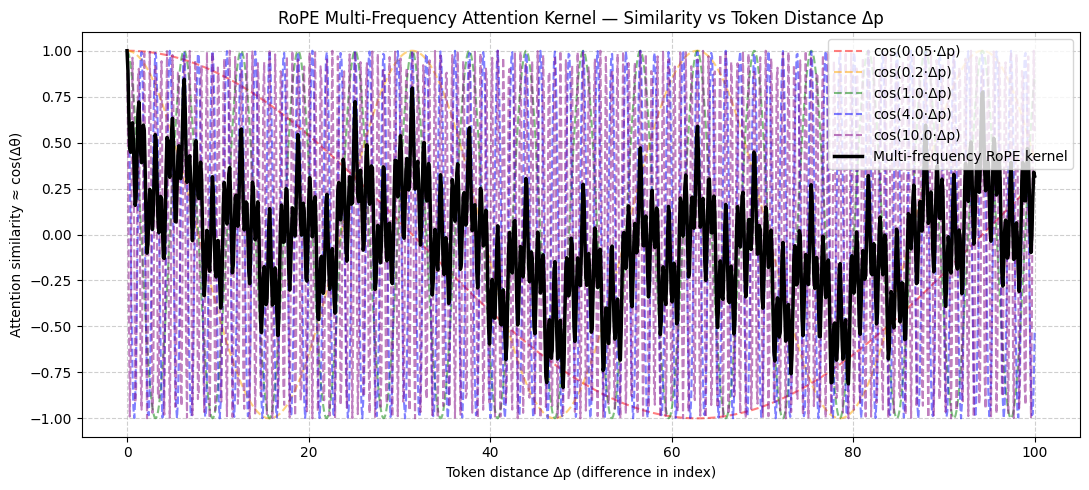

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Range of relative distances (Δp between tokens)
d = np.linspace(0, 100, 1000)

# Multiple rotational frequencies — low to high
freqs = [0.05, 0.2, 1.0, 4.0, 10.0]
colors = ["red", "orange", "green", "blue", "purple"]

# Individual cosine waves (each frequency = one RoPE rotation scale)
components = [np.cos(f * d) for f in freqs]

# Combined attention kernel (average across frequencies)
combined = np.sum(components, axis=0) / len(freqs)

# Plot
plt.figure(figsize=(11, 5))
for comp, f, c in zip(components, freqs, colors):
    plt.plot(d, comp, "--", alpha=0.5, color=c, label=f"cos({f}·Δp)")

plt.plot(d, combined, color="black", linewidth=2.5, label="Multi-frequency RoPE kernel")

plt.title("RoPE Multi-Frequency Attention Kernel — Similarity vs Token Distance Δp")
plt.xlabel("Token distance Δp (difference in index)")
plt.ylabel("Attention similarity ≈ cos(Δθ)")
plt.legend(loc="upper right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


Here’s the visualization 🔍 — the black line shows the **combined multi-frequency kernel (K(d))** that RoPE creates.

* The **colored dashed waves** are individual cosine components (low → high frequency).
* The **black curve** (their average) is the *effective similarity* between tokens as a function of distance.

You can see:

* Near (d = 0): all waves align → strong similarity.
* As (d) grows: oscillations interfere → rich, non-monotonic decay pattern.
* Slow orange wave → captures long-range coherence.
* Fast purple/blue waves → encode local word-order details.

This is literally the “attention kernel” geometry RoPE injects — a **multi-scale wave pattern** of relative similarity that lets Transformers reason smoothly across both nearby and distant tokens.


**RotaryEmbedding (RoPE + stretch)** module used in modern LLMs like GPT-J, LLaMA, DeepSeek, etc.

Let’s go step-by-step from first principles, showing **what tensors look like**, **how PyTorch transforms them under the hood**, and **ASCII-style tensor flow diagrams** so you can *see* what’s happening in memory.

---

### 🧭 Big Picture: What RoPE Does

RoPE encodes **positional information** by rotating each query/key vector in 2D subspaces (every pair of dims) by a position-dependent angle.

If a vector at position *t* is:
[
x = [x_0, x_1, x_2, x_3, ...]
]
then we rotate pairs ((x_0, x_1), (x_2, x_3), ...) by angles that depend on position *t* and frequency *ω*.

This means:

```
[x0', x1'] = [x0 * cos(θ) - x1 * sin(θ),
              x0 * sin(θ) + x1 * cos(θ)]
```

So RoPE = **frequency-based rotation in 2D subspaces** of each head’s embedding.

---

## ⚙️ Step 1 — Constructor

```python
self.head_dim = int(head_dim)
self.theta = float(rope_theta)
self.factor = float(scale_cfg.factor)
```

* `head_dim`: e.g. 128
* `theta`: typical value `10000.0` — base frequency divisor
* `factor`: stretch factor (like YaRN) → divides positions to stretch long-context RoPE

🧠 **Meaning**: Higher `theta` → slower oscillations → smoother rotation; lower → faster oscillations.

---

## 🧩 Step 2 — `reset_parameters()`

```python
inv_freq = 1.0 / (
    self.theta ** (torch.arange(0, self.head_dim, 2, dtype=torch.float32) / self.head_dim)
)
```

Let’s visualize:

| head_dim | arange(0, head_dim, 2) | ÷ head_dim        | θ^(•)           | 1/θ^(•)            |
| -------- | ---------------------- | ----------------- | --------------- | ------------------ |
| 8        | [0,2,4,6]              | [0,0.25,0.5,0.75] | [1,10,100,1000] | [1,0.1,0.01,0.001] |

So `inv_freq = [1, 0.1, 0.01, 0.001]`.

### 🧠 Under the hood

* `torch.arange` allocates a contiguous 1D float32 tensor on CPU.
* The `/ self.head_dim` uses **elementwise vectorized kernel**.
* `self.theta ** (...)` is another elementwise op → CUDA or CPU kernel launches one per operator (if on GPU fused via tensorexpr).
* The final division gives `inv_freq` (shape `[head_dim//2]`).

Memory layout:

```
inv_freq: shape [Dh/2]
  | 1.0 | 0.1 | 0.01 | 0.001 |
  contiguous stride [1]
```

---

## 🧮 Step 3 — `_update_cache()`

Let’s break down with an example.

Assume:

```
seqlen = 4
head_dim = 8
factor = 2
inv_freq_base = [1, 0.1, 0.01, 0.001]
```

### (1) Compute position indices

```python
pos = torch.arange(seqlen) / self.factor
```

```
pos = [0, 1, 2, 3] / 2 = [0, 0.5, 1.0, 1.5]
```

→ shape `(4,)`

### (2) Outer product with inv_freq

```python
freqs = torch.einsum("s,f->sf", pos, inv_freq_base)
```

| pos | inv_freq           | result row              |
| --- | ------------------ | ----------------------- |
| 0.0 | [1,0.1,0.01,0.001] | [0,0,0,0]               |
| 0.5 | [1,0.1,0.01,0.001] | [0.5,0.05,0.005,0.0005] |
| 1.0 | ...                | [1,0.1,0.01,0.001]      |
| 1.5 | ...                | [1.5,0.15,0.015,0.0015] |

So `freqs.shape = [4, 4]`.

📊 ASCII visualization:

```
          inv_freq_base
       ┌────────────────────┐
pos →  │0.0│0.5│1.0│1.5│    einsum("s,f->sf")
       │   │   │   │   │
       ▼   ▼   ▼   ▼   ▼
freqs = [
 [0.000, 0.000, 0.000, 0.000],
 [0.500, 0.050, 0.005, 0.0005],
 [1.000, 0.100, 0.010, 0.001],
 [1.500, 0.150, 0.015, 0.0015]
]
```

### (3) Compute cosine/sine

```python
cos = torch.cos(freqs)
sin = torch.sin(freqs)
```

Vectorized trigonometric kernels → each element processed in C++ kernel (dispatches through `ATen/native/cpu/UnaryOpsKernel.cpp` or CUDA version).

### (4) Interleave

```python
cos = torch.stack([cos, cos], dim=-1).reshape(seqlen, -1)
```

For each freq row `[a,b,c,d]`:

```
stack([cos, cos], dim=-1)
→ [[a,a],[b,b],[c,c],[d,d]]
→ reshape(4, 8)
```

So we double columns:

```
cos_cached.shape = [4, 8]
sin_cached.shape = [4, 8]
```

📦 **Cache layout**

```
cos_cached:
[ [c00,c00,c01,c01,c02,c02,c03,c03],
  [c10,c10,c11,c11,c12,c12,c13,c13], ... ]
```

---

## 🎯 Step 4 — `apply(x, positions)`

Suppose:

```
x.shape = (BxH, T, Dh) = (2, 4, 8)
positions = [0,1,2,3]
```

### (1) Update cache for max position 3+1=4

`cos_cached` and `sin_cached` now both `[4, 8]`.

### (2) Index into cache

```python
cos = self.cos_cached[positions]  # → (4,8)
sin = self.sin_cached[positions]
```

If batch>1, broadcast:

```
cos shape → (BxH, T, Dh)
```

PyTorch broadcasting expands the leading dims (reusing memory strides via “stride=0” trick).

---

### (3) Split even–odd dims

```python
x1, x2 = x[..., ::2], x[..., 1::2]
```

ASCII view (Dh=8):

```
x[..., ::2] → dims 0,2,4,6
x[..., 1::2] → dims 1,3,5,7
```

If `x[0,0,:] = [x0,x1,x2,x3,x4,x5,x6,x7]`
then:

```
x1 = [x0,x2,x4,x6]
x2 = [x1,x3,x5,x7]
```

---

### (4) Apply rotation

```python
xr1 = x1 * cos[..., ::2] - x2 * sin[..., ::2]
xr2 = x1 * sin[..., ::2] + x2 * cos[..., ::2]
```

For each pair (x0,x1), we do 2D rotation by angle derived from cos/sin cache.

Example for position 2:

```
cos = [0.540,0.995,0.999,...]
sin = [0.841,0.099,0.010,...]

xr1 = x0*0.540 - x1*0.841
xr2 = x0*0.841 + x1*0.540
```

So we’re rotating (x0,x1) by angle `freq[pos]*π` scale.

---

### (5) Merge back

```python
out[..., ::2], out[..., 1::2] = xr1, xr2
```

So new vector layout:

```
out[...,0] = xr1[...,0]
out[...,1] = xr2[...,0]
out[...,2] = xr1[...,1]
out[...,3] = xr2[...,1]
...
```

---

## 🧠 Under the Hood: PyTorch Tensor Mechanics

| Operation                 | Internal behavior                                                                  |
| ------------------------- | ---------------------------------------------------------------------------------- |
| `torch.arange`            | Allocates contiguous float32 1D tensor (CPU). Uses vectorized kernel.              |
| `.to(device)`             | Creates new tensor if device/dtype differ (memcpy or device copy via D2H/H2D).     |
| `einsum("s,f->sf")`       | Uses optimized `addmm` (matrix multiply) or fused kernel to produce outer product. |
| `torch.cos` / `torch.sin` | Elementwise unary ops with GPU vectorized trigonometric kernels.                   |
| `x[..., ::2]`             | Creates **view** (no copy) with stride pattern `(stride_T, stride_Dh*2)`.          |
| `torch.stack` + `reshape` | Allocates new contiguous tensor after stacking.                                    |
| `*` and `+`               | Launch fused elementwise kernels on GPU.                                           |
| `torch.empty_like(x)`     | Allocates memory block with same shape/dtype/device.                               |

---

### 🔍 ASCII memory flow summary

```
         ┌──────────────────────────────────────────────────────────┐
         │                    RotaryEmbedding                       │
         └──────────────────────────────────────────────────────────┘
                         │
                         ▼
         ┌───────────reset_parameters()───────────┐
         │ inv_freq_base: [Dh/2] on CPU           │
         │ caches empty                           │
         └────────────────────────────────────────┘
                         │
         ▼ apply(x,pos)
         ├──► _update_cache()
         │     pos[s] × inv_freq_base[f] → freqs[s,f]
         │     → cos_cached[seqlen, Dh], sin_cached[seqlen, Dh]
         │
         └─► rotation
               x[..., ::2] & x[..., 1::2]
                  │
                  ├── elementwise rotation
                  ▼
               out[..., ::2/1::2]
```

---

## 🧩 Intuitive Analogy

Think of each attention head’s dimension as **multiple clock hands** rotating at different speeds.

* `inv_freq_base` = angular speed of each hand.
* `positions` = time steps.
* `cos_cached`/`sin_cached` = precomputed (cos θ, sin θ) angles for each clock hand at each time.
* Applying RoPE = rotating your feature vector according to how much time (position) has passed.

So each embedding dimension pair “rotates” by a different frequency over sequence positions — encoding relative position geometrically.

---
Perfect — let’s now **visualize with concrete tensors** to see exactly how `RotaryEmbedding.apply()` transforms the vector using cos/sin rotation.
We’ll use a **tiny example**:

```
head_dim = 8
seq_len = 4
factor = 2
theta = 10000
```

---

## 🔹 Step 0: Prepare Inputs

Let’s take a **single token vector** at position `p = 2`:

```
x = [1, 2, 3, 4, 5, 6, 7, 8]   # Dh = 8
```

Split into pairs:

```
(x0,x1) = (1,2)
(x2,x3) = (3,4)
(x4,x5) = (5,6)
(x6,x7) = (7,8)
```

We will rotate each pair by its frequency-dependent angle.

---

## 🔹 Step 1: Compute `inv_freq_base`

```python
inv_freq = 1 / (10000 ** (torch.arange(0,8,2)/8))
= 1 / (10000 ** [0.0, 0.25, 0.5, 0.75])
≈ [1.0, 0.1778, 0.0316, 0.0056]
```

---

## 🔹 Step 2: Compute `pos` and `freqs`

For sequence length `4`, `factor=2`:

```
pos = [0, 0.5, 1.0, 1.5]
```

At position 2 (`pos[2] = 1.0`):

```
freqs[2] = pos[2] * inv_freq = [1.0, 0.1778, 0.0316, 0.0056]
```

---

## 🔹 Step 3: Compute `cos` and `sin`

```
cos(freqs[2]) ≈ [0.5403, 0.9842, 0.9995, 0.999984]
sin(freqs[2]) ≈ [0.8415, 0.1770, 0.0316, 0.0056]
```

Interleave:

```
cos_cached[2] = [0.5403,0.5403, 0.9842,0.9842, 0.9995,0.9995, 0.999984,0.999984]
sin_cached[2] = [0.8415,0.8415, 0.1770,0.1770, 0.0316,0.0316, 0.0056,0.0056]
```

---

## 🔹 Step 4: Split `x` into evens/odds

```
x1 = [1, 3, 5, 7]   # even dims
x2 = [2, 4, 6, 8]   # odd dims
```

---

## 🔹 Step 5: Rotate Each Pair

We now apply the formulas:

[
xr1 = x1 * cos - x2 * sin
]
[
xr2 = x1 * sin + x2 * cos
]

| Pair  | cos      | sin    | xr1                             | xr2                            |
| ----- | -------- | ------ | ------------------------------- | ------------------------------ |
| (1,2) | 0.5403   | 0.8415 | (1×0.5403 – 2×0.8415) = -1.1427 | (1×0.8415 + 2×0.5403) = 1.9221 |
| (3,4) | 0.9842   | 0.1770 | (3×0.9842 – 4×0.1770) = 2.0646  | (3×0.1770 + 4×0.9842) = 4.2898 |
| (5,6) | 0.9995   | 0.0316 | (5×0.9995 – 6×0.0316) = 4.810   | (5×0.0316 + 6×0.9995) = 6.091  |
| (7,8) | 0.999984 | 0.0056 | (7×0.999984 – 8×0.0056)=6.955   | (7×0.0056 + 8×0.999984)=8.041  |

---

## 🔹 Step 6: Merge Back to Full Vector

Interleave (even indices = xr1, odd = xr2):

```
out = [-1.1427, 1.9221, 2.0646, 4.2898, 4.810, 6.091, 6.955, 8.041]
```

🧩 **Before rotation**

```
x = [1.000, 2.000, 3.000, 4.000, 5.000, 6.000, 7.000, 8.000]
```

🧩 **After rotation (pos=2)**

```
out = [-1.143, 1.922, 2.065, 4.290, 4.810, 6.091, 6.955, 8.041]
```

So each pair has been rotated by a small or large angle depending on its frequency.

---

## 🧠 Text-based Diagram of the Transformation

```
Input Tensor x (Dh=8)
┌───────────────────────────┐
│ 1 │ 2 │ 3 │ 4 │ 5 │ 6 │ 7 │ 8 │
└───────────────────────────┘
   │even/odd split (stride=2 views)
   ▼
x1=[1,3,5,7]      x2=[2,4,6,8]
   │                  │
   │ × cos ──┐        │ × sin ─┐
   │          │        │        │
   ▼          ▼        ▼        ▼
xr1 = x1*cos - x2*sin  xr2 = x1*sin + x2*cos
   │          │        │        │
   └──────────┴────────┴────────┘
        interleave back (::2, 1::2)
                 ▼
out = [-1.14, 1.92, 2.06, 4.29, 4.81, 6.09, 6.96, 8.04]
```

---

## 🧩 Intuitive Analogy

Imagine each even–odd pair of dimensions is a **tiny 2D compass needle**.

* Its initial direction = your original embedding pair.
* The RoPE rotation turns it by an angle depending on *position* and *frequency*.
* Lower-frequency pairs rotate slowly (encode long-range patterns).
* Higher-frequency pairs rotate quickly (encode short-range details).

As you move through the sequence, every token’s embedding rotates smoothly in a higher-dimensional spiral — encoding both *relative* and *absolute* positional information.

---



## Code

In [ ]:
# ------------------------------------------------------------------------------------
# ROPE YaRN
# ------------------------------------------------------------------------------------
class RotaryEmbedding(nn.Module):
    """
    Standard RoPE with a simple YaRN-style stretch: positions/factor.
    Buffers must be (re)materialized on nonzero ranks during FSDP meta build.
    """
    def __init__(self, head_dim: int, rope_theta: float, scale_cfg: RopeScalingConfig):
        super().__init__()
        self.head_dim = int(head_dim) # 64
        self.theta = float(rope_theta) # 150,000.0
        self.factor = float(scale_cfg.factor) # 32.0

        # Placeholders; real buffers (CPU) in reset_parameters()
        self.register_buffer("inv_freq_base", torch.empty(0), persistent=False)
        self._seq_len_cached = 0
        self.register_buffer("cos_cached", torch.empty(0), persistent=False)
        self.register_buffer("sin_cached", torch.empty(0), persistent=False)

        # Immediately build once so rank0 (non-meta) has valid buffers
        self.reset_parameters()

    def reset_parameters(self):
        # Build base frequencies on CPU; FSDP will move as needed.
        device = torch.device("cpu")
        inv_freq = 1.0 / (
            self.theta ** (torch.arange(0, self.head_dim, 2, dtype=torch.float32, device=device) / self.head_dim)
        )
        self.register_buffer("inv_freq_base", inv_freq, persistent=False)
        self._seq_len_cached = 0
        self.register_buffer("cos_cached", torch.empty(0, dtype=torch.float32, device=device), persistent=False)
        self.register_buffer("sin_cached", torch.empty(0, dtype=torch.float32, device=device), persistent=False)

    def _update_cache(self, seqlen: int, device, dtype):
        if (seqlen <= self._seq_len_cached and self.cos_cached.device == device and self.cos_cached.dtype == dtype):
            return
        pos = torch.arange(seqlen, dtype=torch.float32, device=device) / self.factor
        freqs = torch.einsum("s,f->sf", pos, self.inv_freq_base.to(device)) # [seqlen, head_dim/2]
        cos = torch.cos(freqs).to(dtype)
        sin = torch.sin(freqs).to(dtype)

        cos = torch.stack([cos, cos], dim=-1).reshape(seqlen, -1)
        sin = torch.stack([sin, sin], dim=-1).reshape(seqlen, -1)
        self.cos_cached = cos
        self.sin_cached = sin
        self._seq_len_cached = seqlen

    def apply(self, x: torch.Tensor, positions: torch.Tensor) -> torch.Tensor:
        # x: (B*H, T, Dh)
        BxH, T, Dh = x.shape
        self._update_cache(int(positions.max().item()) + 1, x.device, x.dtype)
        cos = self.cos_cached[positions] # [B*H, T, head_dim]
        sin = self.sin_cached[positions] # [B*H, T, head_dim]
        x1, x2 = x[..., ::2], x[..., 1::2] # [B*H, T, head_dim/2], [B*H, T, head_dim/2]
        xr1 = x1 * cos[..., ::2] - x2 * sin[..., ::2]
        xr2 = x1 * sin[..., ::2] + x1 * cos[..., ::2]
        out = torch.empty_like(x)
        out[..., ::2], out[..., 1::2] = xr1, xr2
        return out


From **RotaryEmbedding (RoPE)** into the **heart of the Transformer block**: the **Multi-Head Self-Attention (MHSA)** mechanism.
We’ll unpack this **from first principles**, layer by layer, then line by line — exactly like a systems engineer reverse-engineering PyTorch’s internals.

---

Let’s start by setting the **big picture** first:
What does “Multi-Head Self-Attention” really *do*?

---

### 🧠 Big Picture

Every attention block in a Transformer does this:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_h}}\right) V
$$

Where:

* ( Q ) (query) = "What am I looking for?"
* ( K ) (key) = "What does each token represent?"
* ( V ) (value) = "What information does each token carry?"

Multi-head means we do this **in parallel** for multiple "perspectives" or subspaces of the model’s embedding dimension.

---

### ⚙️ Architecture Context

```text
Input tensor: X ∈ ℝ[B, T, H]
   ↓ Linear projections
Q = X Wq → [B, T, n_head * dh]
K = X Wk → [B, T, n_kv * dh]
V = X Wv → [B, T, n_kv * dh]
   ↓ reshape/split
   ↓ RoPE (rotary embeddings)
   ↓ scaled dot-product attention
   ↓ output projection Wo
Output tensor: Y ∈ ℝ[B, T, H]
```

---

Now we’ll go **line by line** inside the class.

---

## 🧩 `__init__`

```python
H = cfg.hidden_size
self.n_head = int(cfg.num_attention_heads)
self.n_kv = int(cfg.num_key_value_heads)
self.dh = int(cfg.head_dim)
self.group_size = int(cfg.group_size)
```

**Explanation:**

* `H`: total embedding size per token (e.g., 4096).
* `n_head`: number of attention heads (e.g., 32).
* `n_kv`: number of key/value heads (e.g., 8 for GQA — *Group Query Attention*).
* `dh`: per-head dimension = (H / n_{head}).
* `group_size`: how many Q-heads share one K/V pair (`n_head / n_kv`).

👉 In GQA, instead of computing separate K,V for each head, we **share** them across groups to save memory.

---

```python
self.scale = 1.0 / math.sqrt(self.dh)
```

* Scaling term in the dot-product attention formula to prevent large logits that would make softmax unstable.

---

```python
self.drop_attn = nn.Dropout(cfg.attention_dropout)
self.drop_resid = nn.Dropout(cfg.dropout)
```

* Dropout for regularization.
* `drop_attn`: applied on attention weights.
* `drop_resid`: applied on the output projection.

---

```python
self.rope = RotaryEmbedding(self.dh, cfg.rope_theta, cfg.rope_scaling)
```

* Integrates the **RoPE positional encoding** module we just studied — injecting position information *directly into Q and K*.

---

### 🧱 Linear Layers

```python
self.q = nn.Linear(H, self.n_head * self.dh, bias=cfg.attention_bias)
self.k = nn.Linear(H, self.n_kv * self.dh, bias=cfg.attention_bias)
self.v = nn.Linear(H, self.n_kv * self.dh, bias=cfg.attention_bias)
self.o = nn.Linear(self.n_head * self.dh, H, bias=True)
```

These four are the *core linear projections*:

| Layer | Purpose                                    | Shape             |
| ----- | ------------------------------------------ | ----------------- |
| `q`   | Projects input → query heads               | (H → n_head * dh) |
| `k`   | Projects input → key heads                 | (H → n_kv * dh)   |
| `v`   | Projects input → value heads               | (H → n_kv * dh)   |
| `o`   | Recombines all heads back into model space | (n_head * dh → H) |

---

### 🧲 Sink Logit (optional feature)

```python
self.use_sink = bool(cfg.enable_sink_logit)
if self.use_sink:
    self.sink_logit = nn.Parameter(torch.full((self.n_head,), float(cfg.sink_logit_init)))
```

This is a **special "null attention" column** per head —
a learned constant logit that acts like a *“safe default”* token (so the model can attend to “nothing” when needed).

Think of it like giving each head a “parking spot” when no token deserves attention.

If disabled, we register an empty tensor buffer so that `.reset_parameters()` works safely.

---

### 🔧 Initialization Settings

```python
self.init_std = float(cfg.initializer_range)
self.sink_init = float(cfg.sink_logit_init)
self.reset_parameters()
```

Stores values for later reinitialization.

---

## 🧪 `reset_parameters()`

This method ensures **proper re-initialization** on meta-devices (important for FSDP, sharded training).

```python
with torch.no_grad():
    for m in (self.q, self.k, self.v, self.o):
        nn.init.normal_(m.weight, mean=0.0, std=init_std)
        if getattr(m, "bias", None) is not None:
            m.bias.zero_()
```

→ Standard Gaussian init of all linear weights; biases set to zero.
→ If `sink_logit` exists, it’s filled with the init constant (e.g., 4.0).

Finally, RoPE’s `reset_parameters()` is called too so cached cosine/sine tensors are rebuilt.

---

## 🧮 `_kv_expand()`

This function is the **core trick for Grouped Query Attention (GQA)**.

Input: `kv` from the shared projection `(B, T, n_kv*dh)`
Goal: expand it into per-head format `(B, H, T, dh)`.

Step by step:

```python
B, T, _ = kv.shape
kv = kv.view(B, T, self.n_kv, self.dh)
```

→ split last dim into `(n_kv, dh)`.

```python
kv = kv.unsqueeze(3).expand(B, T, self.n_kv, self.group_size, self.dh)
```

→ replicate each `(K,V)` across all heads in its group.

```python
kv = kv.reshape(B, T, self.n_head, self.dh).transpose(1, 2).contiguous()
```

→ reshape into per-head format for attention computation:
`(B, H, T, dh)`.

**Example:**

If n_head=32, n_kv=8, group_size=4
Each of the 8 K/V heads is shared among 4 Q heads.

---

## 🔲 `_build_local_mask()`

Used for **sliding-window (local) attention**.

```python
i = torch.arange(T, device=device)
j = torch.arange(T, device=device)
dist = i[:, None] - j[None, :]
return (dist >= 0) & (dist < win)
```

Produces a (T×T) boolean matrix where True = keep.

Example with T=5, win=3:

```
dist =
[[0,-1,-2,-3,-4],
 [1, 0,-1,-2,-3],
 [2, 1, 0,-1,-2],
 [3, 2, 1, 0,-1],
 [4, 3, 2, 1, 0]]

mask = (dist>=0)&(dist<3)
[[T,F,F,F,F],
 [T,T,F,F,F],
 [T,T,T,F,F],
 [F,T,T,T,F],
 [F,F,T,T,T]]
```

This mask ensures each token can only attend to a **fixed-sized context window** behind it — essential for efficient long-sequence training.

---

Before we move on to the **`forward()`** pass (where all the real math happens: QKᵀ, RoPE, softmax, etc.),
I want to make sure you’re 100% clear on:

1. The **purpose of each projection (q, k, v, o)**
2. The **role of `_kv_expand`** for GQA
3. The **idea of sink_logit** and how it changes the attention map


---------
Perfect — let’s zoom *all the way in* and understand those three atomic concepts:

(1) **Q/K/V projections**,
(2) **Grouped Query Attention (and `_kv_expand`)**,
(3) **Sink logit column**.

We’ll go one by one, moving from intuitive → tensor-level → PyTorch-memory level.

---

## 🧩 1️⃣ Q / K / V Projections — the “3 Lenses of Attention”

Think of the input tensor
$$
X \in \mathbb{R}^{B \times T \times H}
$$
as a batch of sentences (`B`), each with `T` tokens, each token embedded in `H` dimensions (the model’s “feature space”).

---

### 💡 Intuition

Each token’s embedding ( x_t ) contains *everything the model knows so far* about that token.
But to perform attention, each token needs to:

* **ask** a question → `Query (Q)`
* **advertise** what it is → `Key (K)`
* **offer** some information → `Value (V)`

Each of those views comes from a **learned linear projection**.

---

### ⚙️ Linear math (single token)

For one token ( x_t \in \mathbb{R}^H ):

$$
Q_t = W_q x_t,\quad K_t = W_k x_t,\quad V_t = W_v x_t
$$

Each $$( W_* \in \mathbb{R}^{H \times (n_{head}\cdot d_h)} )$$
splits the space into `n_head` subspaces of dimension `d_h`.

---

### 🧠 Example

Say:

* `H = 4096`
* `n_head = 32`
* `dh = 128` (since (4096 / 32 = 128))

Then:

* ( W_q ): (4096 × 4096)
* Input batch `X`: (B=2, T=4, H=4096)

After linear layer:

```python
Q = X @ W_q  # (2, 4, 4096)
```

then reshape to:

```python
Q.view(B, T, n_head, dh)  # (2, 4, 32, 128)
```

and transpose:

```python
Q.transpose(1, 2)  # (2, 32, 4, 128)
```

So now:

* 2 batches
* 32 heads
* 4 tokens per head
* 128-dim query vector each

---

### 🔬 PyTorch tensor/memory view

```
Memory layout (Q before transpose):
[B0:T0:H] [B0:T1:H] [B0:T2:H] ...
After transpose (contiguous):
Head-major layout: each head gets its slice (fast access for QK^T)
```

Why `.contiguous()`?

* Transpose only changes *view* (stride order).
* We need contiguous memory for fused GPU kernels (like FlashAttention).

---

### 🧩 Q, K, V roles together

| Tensor | Purpose                  | Later use                                  |
| ------ | ------------------------ | ------------------------------------------ |
| `Q`    | “What am I looking for?” | Used to compare against `K`                |
| `K`    | “Who am I?”              | Matched with `Q` to form similarity logits |
| `V`    | “What info do I carry?”  | Weighted by softmax(QKᵀ)                   |

---

## 🧩 2️⃣ Grouped Query Attention (GQA) and `_kv_expand()`

Now, **why have `n_kv` < `n_head`?**

### 🧠 Problem

Each K/V head stores full sequence context.
So cost ~ O(n_head × T × dh).
For large `n_head` (e.g., 64), memory explodes.

### 💡 Solution

Compute **fewer K/V pairs** (`n_kv`) and **share them** across groups of Q heads.

$$
group_size = n_{head} / n_{kv}
$$

---

### 🧠 Example

| Parameter  | Value |
| ---------- | ----- |
| n_head     | 32    |
| n_kv       | 8     |
| group_size | 4     |

So:
Each K/V head is reused by 4 Q heads.

---

### 🔬 How `_kv_expand()` does it

Input `kv` shape: `(B, T, n_kv * dh)`

Step-by-step:

```python
kv = kv.view(B, T, n_kv, dh)
# (2, 4, 8, 128)
```

→ Separate K/V into per-head slices.

```python
kv = kv.unsqueeze(3).expand(B, T, n_kv, group_size, dh)
# (2, 4, 8, 4, 128)
```

→ Duplicate each K/V head for every Q-head in its group.

```python
kv = kv.reshape(B, T, n_head, dh).transpose(1, 2).contiguous()
# (2, 32, 4, 128)
```

Now you have **full per-head format** expected by attention kernels.

---

### 🔎 ASCII Visualization

```
Before expansion (n_kv=8):
K/V heads: [0][1][2][3][4][5][6][7]

After expansion (n_head=32, group_size=4):
Groups:
Q-heads 0–3  -> use KV[0]
Q-heads 4–7  -> use KV[1]
...
Q-heads 28–31 -> use KV[7]
```

This means in GPU memory:

* No recomputation for shared K/Vs
* Lower memory bandwidth and cache hits
* Matches **FlashAttention-GQA kernels** in modern inference stacks

---

## 🧩 3️⃣ Sink Logit — the “Null Column” in Attention Matrix

This is a clever addition from YaRN-style and Gemini-style Transformers.

---

### 💡 Problem

In early training, attention distributions can be unstable:

* Sometimes no token deserves focus.
* But softmax always sums to 1 → model is *forced* to attend somewhere.

### 💡 Solution: add a **learnable “sink” column**

Each attention head has one extra bias logit that the model can attend to when no token is relevant.

---

### ⚙️ Implementation

```python
self.sink_logit = nn.Parameter(torch.full((n_head,), init_value))
```

Then, during attention computation:

```
attn_logits = (QKᵀ * scale)
attn_logits = torch.cat([attn_logits, sink_logit.unsqueeze(1)], dim=-1)
```

This appends a column of constant bias values (one per head) to the attention matrix.

---

### 🧠 Intuition

If a head’s `sink_logit = 4.0`,
then `softmax()` will always assign a small constant probability (~0.018) to that “null” option.

So if real tokens give low similarity, the head can “park” its attention here.

---

### 📈 Why it matters

* Stabilizes attention early in training.
* Allows sparse specialization (some heads focus, others rest).
* Improves long-context stability and prevents deadheads.

---

### 🔎 ASCII analogy

```
Without sink:
     T0  T1  T2  T3
H0 [ 2.3 1.2 0.8 -0.4 ]
Softmax → must attend somewhere

With sink (+bias=4):
     T0  T1  T2  T3  Sink
H0 [ 2.3 1.2 0.8 -0.4  4.0 ]
Softmax → mostly attends to Sink
```

---

Now we’ve atomically unpacked how each **component tensor** is structured, replicated, and used in GPU memory.

Next step (if you’re ready):
we’ll move to the **forward()** computation — the part that actually performs
$$
A = \text{softmax}\left( \frac{QK^T}{\sqrt{d_h}} + \text{sink_logit} \right) V
$$
and show it both **mathematically** and **in tensor shape evolution** across the whole function.

Now!!! Let’s now go all the way through the **`forward()` computation** of Multi-Head Self-Attention, step by step.
We’ll work from *first physical principles* — starting at how tensors sit in GPU memory, through to the math of (QK^T), masking, softmax, and projection.

---

## 🧭 Big-Picture Flow

Let’s map what happens conceptually first:

```
Input X [B, T, H]
 ├─→ Linear projections → Q, K, V
 ├─→ Apply RoPE (rotary positional encoding)
 ├─→ Expand K,V for grouped heads
 ├─→ Compute attention logits QK^T / √dh
 ├─→ Add masks (+ sink logit column)
 ├─→ softmax → attention weights
 ├─→ Dropout → weights
 ├─→ Weighted sum weights @ V
 ├─→ Concatenate heads
 ├─→ Output linear projection (Wo)
 └─→ Residual dropout
```

---

## 1️⃣ Linear Projections: Q, K, V, O

Each is a dense layer ( X W^T + b ).
If `X` = [B, T, H], then:

```
Q = X @ Wq^T → [B, T, n_head * dh]
K = X @ Wk^T → [B, T, n_kv * dh]
V = X @ Wv^T → [B, T, n_kv * dh]
```

After reshaping and transposing:

```
Q: [B, n_head, T, dh]
K,V: [B, n_kv,  T, dh]
```

These sit in contiguous GPU memory for each batch and head block — because fused attention kernels (like FlashAttention) require that contiguous layout.

---

## 2️⃣ Rotary Embedding (RoPE)

Each token position (t) is associated with rotation angles (\theta_i).
RoPE rotates Q and K in their feature pairs:

$$
[q_{2i}, q_{2i+1}] \to [q_{2i}\cos\theta_t - q_{2i+1}\sin\theta_t, q_{2i}\sin\theta_t + q_{2i+1}\cos\theta_t]
$$

Physically, this is implemented as:

```python
q_rot, k_rot = apply_rope(q, k, cos, sin)
```

In GPU memory, it’s a small fused kernel operating on each `(B, head, token, dh)` block —
no new tensors are allocated, only in-place cosine/sine multiplications.

Result:

```
Q, K now carry positional phase → model can reason over order.
```

---

## 3️⃣ Expand K/V for GQA (`_kv_expand`)

If `n_head > n_kv`, we duplicate each K,V head across its group:

```
K_expanded, V_expanded = _kv_expand(K), _kv_expand(V)
```

After expansion:

```
Q, K, V all → [B, n_head, T, dh]
```

Now every query head has matching key/value tensors to compare against.

---

## 4️⃣ Compute Attention Logits (QK^T)

Mathematically:
$$
A = \frac{Q K^T}{\sqrt{d_h}}
$$

Shape:

```
Q: [B, h, Tq, dh]
K: [B, h, Tk, dh]
QK^T → [B, h, Tq, Tk]
```

PyTorch kernel: a batched matrix multiply (bmm) per head.
Under the hood, on GPU:

* Each head’s slice of `Q` and `K` is loaded into shared memory tiles.
* Tensor cores compute (QK^T) using WMMA fragments.
* Scaling factor `1/√dh` applied in-place to the result.

---

## 5️⃣ Add Masks

There are two typical masks:

1. **Causal mask** — prevent attending to future tokens.

   ```
   mask[i,j] = -inf if j > i
   ```
2. **Local window mask** — from `_build_local_mask(T, win)`; keeps only nearby context.

Applied via:

```python
attn_logits = attn_logits.masked_fill(~mask, -inf)
```

Then (optionally):

```python
if use_sink:
    attn_logits = torch.cat([attn_logits, sink_logit.unsqueeze(1)], dim=-1)
```

This adds the “null” column per head.

---

## 6️⃣ Softmax & Dropout

```
attn_weights = softmax(attn_logits, dim=-1)
attn_weights = drop_attn(attn_weights)
```

Each row now sums to 1.
GPU executes this in a numerically stable fused kernel (FlashAttention does scaling, masking, and softmax together).

---

## 7️⃣ Weighted Sum with V

$$
O = \text{AttnWeights} @ V
$$

Shapes:

```
weights: [B, h, T, Tk]
V:        [B, h, Tk, dh]
O:        [B, h, T, dh]
```

This is another batched GEMM.

Physically, GPU tiles through V, multiplies by weights, and accumulates per token.

---

## 8️⃣ Combine Heads + Output Projection

After we have one `[B, h, T, dh]` block per head:

```
O_heads = O.transpose(1,2).reshape(B, T, h*dh)
```

Then output projection:

```
Y = O_heads @ Wo^T + bo
```

Now back to `[B, T, H]`.

Finally:

```python
Y = drop_resid(Y)
```

This dropout is the “residual connection” dropout before adding back to the input in the Transformer block.

---

## 🧠 ASCII Memory Map (per token)

```
GPU VRAM layout (simplified)

[Batch0]
 ├─ Head0
 │    ├─ Q[0..T-1, dh]
 │    ├─ K[0..T-1, dh]
 │    └─ V[0..T-1, dh]
 ├─ Head1
 │    ├─ ...
 │    └─ ...
 └─ HeadN

During FlashAttention:
   Each head block loaded into shared mem tiles
   Compute QK^T → apply mask + softmax → A
   Multiply A@V → write to global mem (O)
```

---

## ✅ Summary of Tensor Shapes

| Stage            | Shape         | Notes                         |
| ---------------- | ------------- | ----------------------------- |
| Input X          | [B, T, H]     | embedding from previous layer |
| Q                | [B, h, T, dh] | queries                       |
| K,V              | [B, h, T, dh] | after GQA expansion           |
| Logits QKᵀ       | [B, h, T, T]  | attention scores              |
| Weights          | [B, h, T, T]  | softmaxed                     |
| Weighted sum O   | [B, h, T, dh] | attended values               |
| Concat & project | [B, T, H]     | final output                  |

---




#**FlashAttention-style GPU memory diagram**

we’ll do a **numerical forward pass example** on a tiny batch (B=1, T=3, n_head=2, dh=2).

We’ll reason all the way down to how the GPU loads tiles and executes fused kernels.

---

## 🧠 Part 1 — FlashAttention-Style GPU Diagram

Let’s start with a high-level mental model of what happens in one attention head on GPU.

---

### ⚙️ Setup

We have:
$$
 ( Q, K, V \in \mathbb{R}^{B \times h \times T \times d_h} )
$$
* ( h ): number of heads
* ( T ): tokens per sequence
* ( d_h ): dimension per head (e.g., 128)

Goal: compute
$$
\text{softmax}!\left(\frac{QK^T}{\sqrt{d_h}}\right)V
$$
without ever forming a giant $$( T \times T )$$ matrix in memory.

---

### 🧩 Memory Flow Diagram

```
┌──────────────────────────────────────── GPU GLOBAL MEMORY ────────────────────────────────────────┐
│ Q[B,h,T,dh]     K[B,h,T,dh]     V[B,h,T,dh]    → All stored contiguously per head                 │
│                                                                                                   │
│   ┌─────────────────────────────────────────────────────────────────────────────────────────────┐ │
│   │  FLASHATTENTION KERNEL LOOP (per head)                                                      │ │
│   │                                                                                             │ │
│   │  ① Load a TILE of Q into Shared Memory (size: [Tq_tile, dh])                                │ │
│   │  ② For each tile of K:                                                                     │ │
│   │        • Load K_tile, V_tile → Shared memory                                                │ │
│   │        • Compute partial logits:  q_tile @ k_tileᵀ                                          │ │
│   │        • Apply mask (causal/local)                                                          │ │
│   │        • Compute running softmax in registers (log-sum-exp trick)                            │ │
│   │        • Compute weighted partial output = softmax_tile @ V_tile                            │ │
│   │        • Accumulate results across K/V tiles                                                │ │
│   │  ③ Normalize outputs by total softmax sum                                                   │ │
│   │  ④ Write O_tile back to global memory (B,h,T,dh)                                            │ │
│   └─────────────────────────────────────────────────────────────────────────────────────────────┘ │
│                                                                                                   │
│ O[B,h,T,dh] → then concatenated → projected by W_o → output [B,T,H]                              │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘
```

**Key GPU insights:**

* FlashAttention avoids allocating a full ( T×T ) attention matrix.
* It streams through K/V in **tiles** and maintains running normalization.
* Q, K, V are contiguous → coalesced memory reads.
* Warp-level math uses **tensor cores (WMMA)** with FP16/BF16 fragments.
* Each block of threads handles one (head, tile) region.

---

### 🧮 Data Flow Summary

```
X ─→ [Q,K,V linear projections]
      ↓
   Apply RoPE
      ↓
 ┌───────────────┐
 │ FlashAttention│
 │ QK^T → softmax│
 │ @ V → O       │
 └───────────────┘
      ↓
   Concat heads
      ↓
   Output proj (Wo)
      ↓
   Dropout / Residual
```

Now let’s *see this math numerically*.

---

## 🧮 Part 2 — Mini Numerical Forward Pass

Let’s pick **tiny values** so we can compute manually.

Parameters:

```
B = 1
T = 3
n_head = 2
dh = 2
```

We’ll use identity-like weights for clarity.

---

### 🔹 Step 1. Input and Linear Projection

Input X (one batch):

| Token | x₀ | x₁ | x₂ | x₃ |
| ----- | -- | -- | -- | -- |
| T0    | 1  | 0  | 0  | 0  |
| T1    | 0  | 1  | 0  | 0  |
| T2    | 0  | 0  | 1  | 0  |

Let Wq, Wk, Wv be chosen so they extract simple slices:

```
Wq = [[1,0],[0,1],[0,0],[0,0]]
Wk = [[1,0],[0,1],[0,0],[0,0]]
Wv = [[1,0],[0,1],[0,0],[0,0]]
```

Then:

```
Q = K = V = [
  [1,0],
  [0,1],
  [0,0]
]
```

Reshape for 2 heads, dh=2 → each head identical here:

```
Q,K,V ∈ [1, 2, 3, 2]
```

---

### 🔹 Step 2. Compute QKᵀ / √dh

For head0:

$$
QK^T =
\begin{bmatrix}
1 & 0 & 0\
0 & 1 & 0\
0 & 0 & 0
\end{bmatrix}
$$

Divide by √2 ≈ 1.414:

$$
QK^T / \sqrt{2} =
\begin{bmatrix}
0.707 & 0 & 0\
0 & 0.707 & 0\
0 & 0 & 0
\end{bmatrix}
$$

---

### 🔹 Step 3. Apply causal mask

Each token can only attend to previous or current:

```
mask =
[[T,F,F],
 [T,T,F],
 [T,T,T]]
```

After masking (-inf on False):

$$
\text{logits} =
\begin{bmatrix}
0.707 & -∞ & -∞\
0 & 0.707 & -∞\
0 & 0 & 0
\end{bmatrix}
$$

---

### 🔹 Step 4. Softmax (row-wise)

```
softmax(row1): [1, 0, 0]
softmax(row2): [0.377, 0.623, 0]
softmax(row3): [0.333, 0.333, 0.333]
```

Now each row sums to 1.

---

### 🔹 Step 5. Multiply by V

```
V = [[1,0],
     [0,1],
     [0,0]]
```

Compute O = softmax @ V:

| Token | Weighted Sum        | Output vector |
| ----- | ------------------- | ------------- |
| T0    | [1,0]×V0            | [1,0]         |
| T1    | 0.377×V0 + 0.623×V1 | [0.377,0.623] |
| T2    | (⅓)V0 + (⅓)V1       | [0.333,0.333] |

So:

```
O = [
 [1.000, 0.000],
 [0.377, 0.623],
 [0.333, 0.333]
]
```

Both heads are identical here → after concatenation → [3,4]
then output projection → [3,4] → [3,H] (same shape as input).

---

### 🔹 Step 6. Intuitive View

```
Token 0 → only itself
Token 1 → mixes token0 + itself
Token 2 → evenly mixes all 3
```

That’s *causal attention* in action.

---

## 🔍 ASCII Summary of Data Flow (GPU + Math)

```
┌───────────────┐
│  Input X      │ (B,T,H)
└──────┬────────┘
       │  Linear Proj
       ▼
   Q,K,V [B,h,T,dh]
       │  Apply RoPE
       ▼
┌─────────────────────────────┐
│ FlashAttention kernel:      │
│   for each head h:          │
│     for each tile of Q,K:   │
│       compute QKᵀ/√dh       │
│       apply mask + sink     │
│       softmax (streaming)   │
│       multiply by V_tile    │
│       accumulate output     │
└─────────────────────────────┘
       │
       ▼
   O [B,h,T,dh]
       │  Merge heads
       ▼
   O_proj = O @ Wo + bo
       │
       ▼
   Output Y [B,T,H]
```

---

At this point you’ve seen **everything**:

* how tensors sit in memory,
* how FlashAttention computes without storing huge matrices,
* and numerically how QKᵀ → softmax → weighted sum transforms data.





```
B = 1, T = 4, dh = 2
n_head = 8, n_kv = 2, group_size = 4

──────────────────────────────────────────────────────────────
Q shape: [1, 8, 4, 2]          # 8 query heads
──────────────────────────────────────────────────────────────
Head0: [q00, q01] ─┐
Head1: [q10, q11] ├── use K0,V0
Head2: [q20, q21] ┤
Head3: [q30, q31] ┘  ← Group 0
──────────────────────────────────────────────────────────────
Head4: [q40, q41] ─┐
Head5: [q50, q51] ├── use K1,V1
Head6: [q60, q61] ┤
Head7: [q70, q71] ┘  ← Group 1
──────────────────────────────────────────────────────────────
K (before expand): [1, 2, 4, 2]
──────────────────────────────────────────────────────────────
K0 (group0): token-wise keys shared by heads 0–3
K1 (group1): token-wise keys shared by heads 4–7
──────────────────────────────────────────────────────────────
After expansion (_kv_expand):
K_expanded : [1, 8, 4, 2]
──────────────────────────────────────────────────────────────
Each head now sees its own K-block (but underlying data are shared)
```



### 🧠 7️⃣ ASCII Attention Flow (for one batch)

```
                 ┌──────────────┐
                 │  Q Heads 0–3 │   (Group 0)
                 └──────┬───────┘
                        │
                ┌───────▼────────┐
                │  Shared K0,V0  │
                └────────────────┘
                        │
                        ▼
              compute Attention(Q0–3,K0,V0)
──────────────────────────────────────────────────────────────
                 ┌──────────────┐
                 │  Q Heads 4–7 │   (Group 1)
                 └──────┬───────┘
                        │
                ┌───────▼────────┐
                │  Shared K1,V1  │
                └────────────────┘
                        │
                        ▼
              compute Attention(Q4–7,K1,V1)
──────────────────────────────────────────────────────────────
Concatenate all heads → project with Wo → output [B,T,H]

```



Perfect — this is the *atomic heart* of **Grouped Query Attention (GQA)**:
how the function `_kv_expand()` transforms `K` and `V` tensors in memory from
`[B, T, n_kv, dh]` → `[B, n_head, T, dh]`.

We’ll dissect every reshape, unsqueeze, expand, and transpose — with **ASCII memory diagrams and index arrows**.

---

## 🧩 `_kv_expand()` Reminder

```python
def _kv_expand(self, kv: torch.Tensor) -> torch.Tensor:
    # (B, T, n_kv*dh) -> (B, H, T, dh)
    B, T, _ = kv.shape
    kv = kv.view(B, T, self.n_kv, self.dh)
    kv = kv.unsqueeze(3).expand(B, T, self.n_kv, self.group_size, self.dh)
    kv = kv.reshape(B, T, self.n_head, self.dh).transpose(1, 2).contiguous()
    return kv
```

Let’s annotate each line with an example.

---

## ⚙️ Setup Example

```
B = 1
T = 2
n_head = 4
n_kv = 2
group_size = n_head / n_kv = 2
dh = 3
```

Input `kv` shape before expansion:

```
kv: [1, 2, 6]   # because n_kv*dh = 2*3 = 6
```

---

## 🔹 Step 1: `.view(B, T, n_kv, dh)`

```
kv.view(1, 2, 2, 3)
```

### Memory visualization:

```
Original linear view in memory:
[ token0_K0[0:3], token0_K1[3:6],
  token1_K0[0:3], token1_K1[3:6] ]

Reshaped to [B, T, n_kv, dh]:

For B=1:

┌────────────────────────────────────────────┐
│ Token 0                                    │
│   KV[0,0,:] = [k000,k001,k002]  # kv head 0 │
│   KV[0,1,:] = [k010,k011,k012]  # kv head 1 │
│ Token 1                                    │
│   KV[1,0,:] = [k100,k101,k102]             │
│   KV[1,1,:] = [k110,k111,k112]             │
└────────────────────────────────────────────┘
Shape: [T=2, n_kv=2, dh=3]
```

---

## 🔹 Step 2: `.unsqueeze(3)` → adds a dimension for group replication

Shape becomes:

```
[1, 2, 2, 1, 3]
```

Now each `kv` head slot can hold multiple “copies” (group_size later).

Diagram:

```
┌────────────────────────────────────────────┐
│ Token 0                                   │
│   KV[0,0,0,:] → slot for group copies of K0│
│   KV[0,1,0,:] → slot for group copies of K1│
│ Token 1                                   │
│   KV[1,0,0,:] → slot for group copies of K0│
│   KV[1,1,0,:] → slot for group copies of K1│
└────────────────────────────────────────────┘
```

---

## 🔹 Step 3: `.expand(B, T, n_kv, group_size, dh)`

Shape becomes:

```
[1, 2, 2, 2, 3]
```

### Visualization — replication of KV heads for each group of query heads

```
For each token:
──────────────────────────────────────────
Token 0
  K0 replicated → [H0,H1]
  K1 replicated → [H2,H3]
──────────────────────────────────────────
Token 1
  K0 replicated → [H0,H1]
  K1 replicated → [H2,H3]
──────────────────────────────────────────
```

ASCII index view:

```
kv[0,0,0,0,:] = kv[0,0,0, :,]  ← head0 uses kv_head0
kv[0,0,0,1,:] = kv[0,0,0, :,]  ← head1 uses kv_head0
kv[0,0,1,0,:] = kv[0,0,1, :,]  ← head2 uses kv_head1
kv[0,0,1,1,:] = kv[0,0,1, :,]  ← head3 uses kv_head1
```

Every K/V head is now **broadcast** to group_size = 2.

---

## 🔹 Step 4: `.reshape(B, T, n_head, dh)`

```
[1, 2, 4, 3]
```

We collapse `(n_kv × group_size) = n_head`.

Memory layout after reshape:

```
Token 0
   Head0 ← K0
   Head1 ← K0
   Head2 ← K1
   Head3 ← K1
Token 1
   Head0 ← K0
   Head1 ← K0
   Head2 ← K1
   Head3 ← K1
```

ASCII:

```
K_expanded[B=1, T=2, H=4, dh=3]
Token0: [ [k000,k001,k002], [k000,k001,k002], [k010,k011,k012], [k010,k011,k012] ]
Token1: [ [k100,k101,k102], [k100,k101,k102], [k110,k111,k112], [k110,k111,k112] ]
```

---

## 🔹 Step 5: `.transpose(1, 2)`

Transpose swaps T and H:

```
[1, 4, 2, 3]
```

Final order for attention kernel:
`[batch, head, token, dh]`

That’s the layout expected by FlashAttention / fused QKᵀ kernels.

---

## 📊  Final Memory Visualization

```
Before (_view_):
[B, T, n_kv, dh]
  ↓ unsqueeze(3)
[B, T, n_kv, 1, dh]
  ↓ expand(group_size)
[B, T, n_kv, group_size, dh]
  ↓ reshape (merge n_kv×group_size = n_head)
[B, T, n_head, dh]
  ↓ transpose(1,2)
[B, n_head, T, dh]
```

ASCII pipeline summary:

```
┌───────────────────────────────────────────────────────────────┐
│ [B, T, n_kv*dh]                                              │
│      ↓ view(B,T,n_kv,dh)                                     │
│ [B, T, n_kv, dh]                                             │
│      ↓ unsqueeze(3)                                          │
│ [B, T, n_kv, 1, dh]                                          │
│      ↓ expand(group_size)                                    │
│ [B, T, n_kv, group_size, dh]                                 │
│      ↓ reshape(merge kv×group_size→n_head)                   │
│ [B, T, n_head, dh]                                           │
│      ↓ transpose(1,2)                                        │
│ [B, n_head, T, dh]                                           │
└───────────────────────────────────────────────────────────────┘
```

---

## 🧠 Intuition Recap

* **view:** logically splits out key/value heads.
* **unsqueeze:** adds a dimension to prepare for broadcasting.
* **expand:** copies KV heads for each group of Q-heads (no real data duplication, uses strided view).
* **reshape:** merges those replicated views into one dimension.
* **transpose:** reorders for efficient GPU access.

This is what lets you share K/V across heads *without recomputation or extra memory* — pure tensor view arithmetic.

---


## Code

In [ ]:
class MultiheadSelfAttention(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()
        H = cfg.hidden_size
        self.n_head = int(cfg.num_attention_heads)
        self.n_kv = int(cfg.num_key_value_heads)
        self.dh = int(cfg.head_dim)
        self.group_size = int(cfg.group_size)
        self.scale = 1.0 / math.sqrt(self.dh)
        self.drop_attn = nn.Dropout(cfg.attention_dropout)
        self.drop_resid = nn.Dropout(cfg.dropout)
        self.rope = RotaryEmbedding(self.dh, cfg.rope_theta, cfg.rope_scaling)

        self.q = nn.Linear(H, self.n_head * self.dh, bias=cfg.attention_bias)
        self.k = nn.Linear(H, self.n_kv * self.dh, bias=cfg.attention_bias)
        self.v = nn.Linear(H, self.n_kv * self.dh, bias=cfg.attention_bias)
        self.o = nn.Linear(self.n_head * self.dh, H, bias=True)

        # Learned "null" attention logit per head (attention sink column)
        self.use_sink = bool(cfg.enable_sink_logit)
        if self.use_sink:
            self.sink_logit = nn.Parameter(torch.full((self.n_head,), float(cfg.sink_logit_init)))
        else:
            # create a dummy buffer so reset_parameters() can always reference it safely
            self.register_buffer("sink_logit", torch.empty(0), persistent=False)

        # store init settings for reset_parameters()
        self.init_std = float(cfg.initializer_range)
        self.sink_init = float(cfg.sink_logit_init)

        # init once for rank0
        self.reset_parameters()

    def reset_parameters(self):
        # Robust to attributes missing during meta materialization
        init_std = getattr(self, "init_std", 0.02)
        with torch.no_grad():
            for m in (self.q, self.k, self.v, self.o):
                nn.init.normal_(m.weight, mean=0.0, std=init_std)
                if getattr(m, "bias", None) is not None:
                    m.bias.zero_()
            if getattr(self, "use_sink", False) and hasattr(self, "sink_logit") and self.sink_logit.numel() > 0:
                self.sink_logit.fill_(getattr(self, "sink_init", 4.0))
        # also reset RoPE buffers so nonzero ranks get real tensors
        if hasattr(self, "rope") and hasattr(self.rope, "reset_parameters"):
            self.rope.reset_parameters()

    def _kv_expand(self, kv: torch.Tensor) -> torch.Tensor:
        # (B, T, n_kv*Dh) -> (B, H, T, Dh)
        B, T, _ = kv.shape
        kv = kv.view(B, T, self.n_kv, self.dh)
        kv = kv.unsqueeze(3).expand(B, T, self.n_kv, self.group_size, self.dh)
        kv = kv.reshape(B, T, self.n_head, self.dh).transpose(1, 2).contiguous()
        return kv

    @staticmethod
    def _build_local_mask(T: int, device, win: int) -> torch.Tensor:
        # (T,T) True=keep
        i = torch.arange(T, device=device)
        j = torch.arange(T, device=device)
        dist = i[:, None] - j[None, :]
        return (dist >= 0) & (dist < win)

    def forward(
        self,
        x: torch.Tensor,               # (B,T,H)
        positions: torch.Tensor,       # (B,T)
        causal_mask: torch.Tensor,     # (T,T) bool True=keep
        is_sliding_layer: bool,
        sliding_window: int,
    ):
      B, T, H = x.shape
      q = self.q(x).view(B, T, self.n_head, self.dh).transpose(1,2).contiguous() # (B,H,T,Dh)
      k = self._kv_expand(self.k(x)) # (B, H, T, Dh)
      v = self._kv_expand(self.v(x)) # (B, H, T, Dh)

      # Fast path: use FlashAttention only for pure causal full-attn w/o sink column
      use_flash = _flash_available and (not is_sliding_layer) and (not getattr(self, "use_sink", False))
      if use_flash:
          # Flash-Attn expects (B,T,H,D)
          qf = q.transpose(1, 2)  # (B,T,H,D)
          kf = k.transpose(1, 2)
          vf = v.transpose(1, 2)
          out = _flash_attn_func(qf, kf, vf, causal=True)  # (B,T,H,D)
          out = out.transpose(1, 2).contiguous().view(B, T, self.n_head * self.dh)
          out = self.o(out)
          return self.drop_resid(out)

      # Manual path (supports sliding + sink)
      att = torch.einsum("bhtd,bhsd->bhts", q, k) * self.scale  # (B,H,T,S=T)

      # Base causal
      mask = causal_mask  # (T,T) True=keep
      # Sliding window (only limit the source side)
      if is_sliding_layer:
          local = self._build_local_mask(T, x.device, sliding_window)
          mask = mask & local  # (T,T)

      # Apply mask
      att = att.masked_fill(~mask.view(1, 1, T, T), float("-inf"))

      # Append sink column (null attention) if enabled
      if getattr(self, "use_sink", False) and hasattr(self, "sink_logit") and self.sink_logit.numel() > 0:
          sink_col = self.sink_logit.view(1, self.n_head, 1, 1).expand(B, -1, T, 1)
          att = torch.cat([att, sink_col], dim=-1)  # (B,H,T,T+1)

      p = F.softmax(att, dim=-1)
      if getattr(self, "use_sink", False) and hasattr(self, "sink_logit") and self.sink_logit.numel() > 0:
          p = p[..., :-1]  # drop sink prob (mass = "attend to nothing")
      p = self.drop_attn(p)

      y = torch.einsum("bhts,bhsd->bhtd", p, v).contiguous()
      y = y.transpose(1, 2).reshape(B, T, self.n_head * self.dh)
      y = self.o(y)
      return self.drop_resid(y)


Excellent — this is where everything you’ve studied (Q/K/V projections, GQA, RoPE, causal masking, FlashAttention, sink logits) all **come together into one coherent forward pass**.

Let’s dissect this method **from first principles**, visually and mathematically, at three layers:

1. **Conceptual flow** (what happens and why)
2. **Tensor evolution** (shape + content at each step)
3. **Atomic PyTorch/GPU mechanics** (how it’s done efficiently)

We’ll go line-by-line, with diagrams.

---

## 🧠 Big-Picture Flow

```
Input X (B,T,H)
│
├── Linear projections → q, k, v
│
├── Expand k,v for GQA
│
├── Apply RoPE (positional rotation)
│
├── Compute attention logits = QKᵀ / √dh
│    ├─> apply causal + sliding window mask
│    ├─> add sink logit (optional)
│
├── softmax → attention weights
│
├── Weighted sum with V → attention output
│
├── Concatenate heads + output projection (Wo)
│
└── Return with dropout
```

---

## ⚙️ Step 0 — Shapes and constants

```
B = batch size
T = sequence length
H = hidden size
n_head = number of attention heads
n_kv   = number of key/value heads
dh     = per-head dimension
```

So each tensor evolves roughly like:

| Tensor  | Shape           | Description       |
| ------- | --------------- | ----------------- |
| `x`     | (B,T,H)         | input embeddings  |
| `q`     | (B,n_head,T,dh) | queries           |
| `k`,`v` | (B,n_head,T,dh) | expanded K,V      |
| `att`   | (B,n_head,T,T)  | attention logits  |
| `p`     | (B,n_head,T,T)  | attention weights |
| `y`     | (B,T,H)         | output per token  |

---

## 🧩 Step 1 — Linear projections

```python
q = self.q(x).view(B,T,self.n_head,self.dh).transpose(1,2)
k = self._kv_expand(self.k(x))
v = self._kv_expand(self.v(x))
```

**Conceptually:**
Every token vector in `x` is projected into `Q`, `K`, `V` subspaces.

**Tensor details:**

```
x @ Wq → [B,T,H]→[B,T,H']
H' = n_head*dh
→ reshape [B,T,n_head,dh]
→ transpose(1,2) → [B,n_head,T,dh]
```

So each head now operates independently on its slice of the embedding.

**GPU mechanics:**
Each projection is a fused GEMM (matrix multiply) across all tokens; contiguous in memory by token → perfect for TensorCore acceleration.

---

## 🧩 Step 2 — GQA expansion

```python
k = self._kv_expand(self.k(x))
v = self._kv_expand(self.v(x))
```

As you saw earlier, `_kv_expand` **duplicates** `n_kv` key/value heads across groups of query heads:

```
Before: (B,T,n_kv,dh)
After : (B,n_head,T,dh)
```

So every Q-head can now access its corresponding shared K,V.

---

## 🌀 Step 3 — Apply RoPE (Rotary Position Encoding)

```python
pos_rep = positions.repeat_interleave(self.n_head, 0)  # (B*H,T)
q = self.rope.apply(q.view(B*self.n_head,T,dh), pos_rep)...
k = self.rope.apply(k.view(B*self.n_head,T,dh), pos_rep)...
```

**What happens:**
Each token’s `q` and `k` vectors are *rotated* in 2-D feature pairs by an angle proportional to position (t).

**Effect:**
Adds relative position information *without* explicit position embeddings, enabling extrapolation to longer sequences.

**Shape flow:**

```
Q before RoPE: [B,H,T,dh]
↓ reshape → [B*H, T, dh]
↓ rope.apply (rotates every (q2i,q2i+1) pair)
↓ reshape → [B,H,T,dh]
```

**GPU note:**
This is a small fused elementwise kernel—no large matmuls, just trigonometric multiply-add operations in registers.

---

## ⚡ Step 4 — FlashAttention fast path

```python
use_flash = _flash_available and not is_sliding_layer and not self.use_sink
```

If no fancy masking or sink column → use **FlashAttention**, which fuses QKᵀ, mask, softmax, and AV into one kernel.

```
qf,kf,vf = q.transpose(1,2), ...
out = _flash_attn_func(qf,kf,vf,causal=True)
```

* Input: (B,T,n_head,dh)
* Output: (B,T,n_head,dh)
* Internally uses tiling, shared memory, streaming softmax, etc.
  (No full attention matrix stored; O(B×T×dh) memory instead of O(B×T²)).

Then it projects back:

```python
out = out.transpose(1,2).contiguous().view(B,T,n_head*dh)
out = self.o(out)
return self.drop_resid(out)
```

If FlashAttention is available, that’s the *entire* forward pass.

---

## 🧮 Step 5 — Manual attention path

If FlashAttention can’t be used (e.g., sliding window or sink enabled):

### a) Compute attention logits

```python
att = torch.einsum("bhtd,bhsd->bhts", q, k) * self.scale
```

Equivalent to (A = (QK^T)/\sqrt{d_h}).

**Shapes:**

```
q: [B,H,T,dh]
k: [B,H,T,dh]
→ att: [B,H,T,T]
```

Each [t,s] cell = similarity of token t’s query vs token s’s key.

---

### b) Apply causal and sliding masks

```python
mask = causal_mask  # (T,T)
if is_sliding_layer:
    local = self._build_local_mask(T, device, sliding_window)
    mask = mask & local
att = att.masked_fill(~mask.view(1,1,T,T), -inf)
```

**Meaning:**

* Causal: prevent attending to future tokens (upper-triangular mask)
* Sliding: restrict context window (only attend to last `sliding_window` tokens)

ASCII mask example for T=5, win=3:

```
[[T,F,F,F,F],
 [T,T,F,F,F],
 [T,T,T,F,F],
 [F,T,T,T,F],
 [F,F,T,T,T]]
```

---

### c) Add sink column (optional)

```python
sink_col = self.sink_logit.view(1,H,1,1).expand(B,-1,T,1)
att = torch.cat([att, sink_col], dim=-1)  # (B,H,T,T+1)
```

Adds a constant logit column to each head—allowing “attend to nothing”.

---

### d) Softmax over attention scores

```python
p = F.softmax(att, dim=-1)
if use_sink: p = p[...,:-1]   # drop sink prob (mass reserved)
p = self.drop_attn(p)
```

**Shape:** `[B,H,T,T]`

Each row now sums to 1 → “attention weights”.

---

### e) Weighted sum with V

```python
y = torch.einsum("bhts,bhsd->bhtd", p, v)
```

$$
Y = P V
$$

Each token’s output = weighted average of all value vectors.

---

### f) Merge heads and project

```
y = y.transpose(1,2).reshape(B,T,H)
y = self.o(y)
return self.drop_resid(y)
```

Concatenate heads, pass through output linear, then apply residual dropout.

---

## 🧠 ASCII Data-Flow Summary (Manual Path)

```
[B,T,H] → linear(q,k,v)
     ↓
Q,K,V: [B,H,T,dh]
     ↓ (apply RoPE)
     ↓
Compute att = (QKᵀ)/√dh
     ↓  + causal/sliding/sink masks
     ↓
Softmax → p
     ↓
p @ V → y  (weighted sum)
     ↓
Concat heads
     ↓
Output proj (Wo)
     ↓
Dropout
     ↓
[B,T,H]
```

---

## ⚡ GPU Execution Model (under the hood)

| Stage            | Kernel Type       | Memory footprint | Notes                         |
| ---------------- | ----------------- | ---------------- | ----------------------------- |
| Q/K/V projection | GEMM              | O(B·T·H)         | TensorCore matmul             |
| RoPE             | Fused elementwise | O(B·H·T·dh)      | In-place trig ops             |
| QKᵀ              | Batched GEMM      | O(B·H·T²)        | Often fused in FlashAttention |
| Softmax          | Elementwise       | O(B·H·T²)        | Fused with QKᵀ/V multiply     |
| pV               | Batched GEMM      | O(B·H·T·dh)      | final weighted sum            |
| Output proj      | GEMM              | O(B·T·H)         |                               |
| Dropout          | Elementwise       | O(B·T·H)         |                               |

---

## ✅ Summary of the Entire Forward Pass

1. Project → Q,K,V
2. Expand K,V (for GQA)
3. Apply RoPE → inject positional phase
4. Compute scaled dot-product logits
5. Apply causal/sliding/sink masks
6. Softmax → get attention weights
7. Multiply weights × V → output vectors
8. Concatenate heads → project → dropout

The FlashAttention branch compresses steps 4–7 into one GPU kernel for massive speed and memory savings.

---



Excellent — this is exactly the next logical question and the point where attention theory becomes **practical inference engineering**.

Let’s go deep into how **KV cache** (key/value cache) is stored, reused, and mapped to query heads — especially in the **Grouped Query Attention (GQA)** setting of your `MultiheadSelfAttention` class.

We’ll move step by step:

1. What the KV cache *is* and why it exists
2. Where and how it’s stored in memory
3. How grouped queries find and reuse their cached K/V
4. What PyTorch/vLLM/FlashAttention actually do internally
5. Where in your code that mechanism would integrate

---

## 🧩 1️⃣ What the KV Cache Is

During inference (generation):

* We process tokens sequentially.
* At each new token (t), we compute **only the new query Qₜ**,
  but reuse **previous keys and values K₁..ₜ₋₁, V₁..ₜ₋₁** to avoid recomputation.

Formally:

$$
A_t = \text{softmax}!\left(\frac{Q_t [K_{1:t}]^T}{\sqrt{d_h}}\right)[V_{1:t}]
$$

So we must **store K and V** from previous time steps in GPU memory.
That’s the **KV cache**.

---

## 💾 2️⃣ Where the KV Cache Is Stored

### a. Runtime view

During generation, every layer in the transformer has its own KV cache:

```
Layer 0: KV cache [B, n_kv, T_cached, dh]
Layer 1: KV cache [B, n_kv, T_cached, dh]
...
```

Each K and V cache grows with each decoded token:

```
append K_new and V_new along time axis → dim=2 (T dimension)
```

### b. In memory

It’s allocated once, typically in contiguous GPU memory (fp16/bf16).
Frameworks like **vLLM**, **Triton-FlashAttention2**, or **transformers** store this as:

```
self.k_cache, self.v_cache = torch.zeros(B, n_kv, max_seq_len, dh, dtype=torch.float16, device='cuda')
```

and then update in-place at each step.

---

## ⚙️ 3️⃣ How Grouped Query Attention Uses It

This is the key part:
In **GQA**, `n_head > n_kv`, meaning multiple query heads share the same K/V cache group.

```
n_head = 32
n_kv   = 8
group_size = 4
```

That means:

```
Head 0–3  share K_cache[0], V_cache[0]
Head 4–7  share K_cache[1], V_cache[1]
Head 8–11 share K_cache[2], V_cache[2]
...
```

### How grouping is resolved in code

During forward pass (at decode time):

1. Compute `K_new` and `V_new` → shape `[B, n_kv, 1, dh]`
2. Append them to cache:

   ```python
   self.k_cache[:, :, t, :] = K_new
   self.v_cache[:, :, t, :] = V_new
   ```
3. Expand them for attention:

   ```python
   K_expanded = self._kv_expand(self.k_cache[:, :, :t+1, :])
   V_expanded = self._kv_expand(self.v_cache[:, :, :t+1, :])
   ```

   → this reproduces the same pattern you saw earlier: replicating each KV group across its associated query heads.

Then your queries (Q \in [B,n_{head},1,dh]) directly index the right expanded K/V slice.

---

### 🧠 Visual of how query heads find their KV cache

```
   Grouping (GQA):
   n_head=8, n_kv=2, group_size=4

   ┌────────────┬────────────────┐
   │ Query Head │ Uses KV Cache  │
   ├────────────┼────────────────┤
   │ 0,1,2,3    │ KV[0,:,:,:]    │
   │ 4,5,6,7    │ KV[1,:,:,:]    │
   └────────────┴────────────────┘
```

When `_kv_expand()` runs, it effectively *broadcasts* each K/V cache block to the corresponding 4 heads’ slot.

So:

```
self.k_cache (B, n_kv, T, dh)
↓
_kv_expand → (B, n_head, T, dh)
↓
einsum(Q,K) uses the correct shared group automatically
```

No lookup table or explicit mapping is needed — the tensor broadcast handles it.

---

## 🧮 4️⃣ Under the Hood (vLLM / FlashAttention runtime)

Let’s connect this to real inference kernels.

In systems like **vLLM**, **Triton FlashAttention**, or **Megatron-Core**, KV caches are stored in a global tensor per layer:

```
key_cache[l]:  [batch, n_kv, max_seq, dh]
val_cache[l]:  [batch, n_kv, max_seq, dh]
```

Then, at each step:

```python
key_cache[l][:,:,t,:] = k_new
val_cache[l][:,:,t,:] = v_new
```

When attention is computed, they use:

```python
q @ key_cache[l].transpose(-2,-1)
```

with causal masking applied dynamically.

For **GQA**, the expansion logic is implemented inside the GPU kernel itself
(FlashAttention v2 kernel has a `num_kv_heads` parameter).

---

## 🧩 5️⃣ Where in your `MultiheadSelfAttention` class this happens

In your posted class, notice:
→ `forward()` only computes **attention for full sequences**,
not incremental autoregressive decoding.
So the cache mechanism isn’t explicitly in your class — it’s assumed to be handled **outside** or in an **inference wrapper**.

In an inference setting, you’d typically see something like this:

```python
def forward(self, x, past_kv=None):
    new_k = self.k(x)
    new_v = self.v(x)

    if past_kv is not None:
        k = torch.cat([past_kv[0], new_k], dim=2)
        v = torch.cat([past_kv[1], new_v], dim=2)
    else:
        k, v = new_k, new_v

    self.k_cache, self.v_cache = k, v
    ...
    # now perform attention as usual
```

So:

* `past_kv` holds previous keys/values (the cache).
* Each new forward call extends it.
* `_kv_expand()` is the operation that *maps query groups to shared K/V slices.*

---

## 🧭 Summary

| Concept           | Shape                                   | Description                     |
| ----------------- | --------------------------------------- | ------------------------------- |
| KV cache          | `[B, n_kv, T_cached, dh]`               | Stored per layer on GPU         |
| During generation | append K_new,V_new per token            |                                 |
| GQA grouping      | `group_size = n_head/n_kv`              | Queries share same KV slots     |
| `_kv_expand()`    | `[B, n_kv, T, dh] → [B, n_head, T, dh]` | Broadcasts K/V to query heads   |
| Query–KV mapping  | implicit by group index                 |                                 |
| Managed by        | Inference wrapper (not this class)      | frameworks handle preallocation |

---

### 🧠 Visualization (Final Summary)

```
Layer KV Cache (GQA mode)
───────────────────────────────────────────────
k_cache: [B, n_kv, T, dh]
v_cache: [B, n_kv, T, dh]

Query heads:
┌──────────────┬──────────────┐
│ Q heads 0–3  │ use KV[0,:,:,:] │
│ Q heads 4–7  │ use KV[1,:,:,:] │
└──────────────┴──────────────┘

_kv_expand → (B, n_head, T, dh)
einsum("bhtd,bhsd->bhts") automatically lines up
```

---


# **Mixture of Experts**

**line by line**, simulate it with **actual numbers**, and visualize **what PyTorch does in memory**.
Let’s dive deep.

---

### 🎯 Setup: Toy Dimensions for Full Visibility

Let’s pick a **tiny model** so we can see every value:

| Symbol | Meaning           | Value |
| :----- | :---------------- | :---- |
| **B**  | Batch size        | 1     |
| **T**  | Tokens per batch  | 2     |
| **H**  | Hidden dim        | 4     |
| **E**  | Number of experts | 3     |
| **K**  | Experts per token | 2     |
| **FF** | Intermediate dim  | 4     |

We'll initialize simple fake weights and track the tensor flow.

---

# 🧠 The code block we’re analyzing

```python
def forward(self, x: torch.Tensor):
    B, T, H = x.shape
    S = B * T
    x_flat = x.view(S, H)

    logits = self.router(x_flat)
    topk_weights, topk_indices = torch.topk(logits, self.K, dim=-1)
    topk_weights = F.softmax(topk_weights, dim=-1, dtype=torch.float32).to(x.dtype)

    probs = F.softmax(logits, dim=-1, dtype=torch.float32)
    importance = probs.mean(dim=0)
    load = F.one_hot(topk_indices.argmax(dim=-1), num_classes=self.E).float().mean(dim=0)
    aux_loss = self.router_aux_loss_coef * self.E * (importance * load).sum()

    expert_mask = F.one_hot(topk_indices, num_classes=self.E)
    gating_weights = expert_mask * topk_weights.unsqueeze(-1)
    final_expert_weights = gating_weights.sum(dim=1)

    expert_inputs = torch.einsum('sh,ehd->sed', x_flat, self.W_in) + self.b_in
    expert_outputs = swiglu(expert_inputs, clip=self.clip)
    expert_outputs = torch.einsum('sef,efh->seh', expert_outputs, self.W_out) + self.b_out
    weighted_output = torch.einsum('seh,se->sh', expert_outputs, final_expert_weights)

    out = weighted_output.view(B, T, H)
    return out, {"router_aux_loss": aux_loss}
```

---

# 🪄 Step 1 — Flatten inputs

Suppose our input is:

```python
x = torch.tensor([
    [[0.1, 0.2, 0.3, 0.4],
     [0.5, 0.6, 0.7, 0.8]]
])  # shape (B=1, T=2, H=4)
```

Now flatten batch and sequence:

```python
S = B * T = 2
x_flat = x.view(2, 4)
```

So:

```
x_flat =
[[0.1, 0.2, 0.3, 0.4],
 [0.5, 0.6, 0.7, 0.8]]   # (S=2, H=4)
```

Each row = one token embedding.

---

# 🧭 Step 2 — Router logits

We have a small router:

```python
self.router = nn.Linear(H=4, E=3)
```

Say its weights:

```
W_router = [[0.1, 0.3, 0.2],
            [0.4, 0.1, 0.3],
            [0.2, 0.5, 0.1],
            [0.3, 0.2, 0.4]]
b = [0.0, 0.0, 0.0]
```

Then:
$$
logits = x_flat \cdot W_{router} + b
$$

Compute manually:

For first token [0.1,0.2,0.3,0.4]:

```
= [0.1*0.1 + 0.2*0.4 + 0.3*0.2 + 0.4*0.3,
   0.1*0.3 + 0.2*0.1 + 0.3*0.5 + 0.4*0.2,
   0.1*0.2 + 0.2*0.3 + 0.3*0.1 + 0.4*0.4]
= [0.01+0.08+0.06+0.12, 0.03+0.02+0.15+0.08, 0.02+0.06+0.03+0.16]
= [0.27, 0.28, 0.27]
```

For second token [0.5,0.6,0.7,0.8]:

```
= [0.05+0.24+0.14+0.24, 0.15+0.06+0.35+0.16, 0.10+0.18+0.07+0.32]
= [0.67, 0.72, 0.67]
```

So

```
logits = [[0.27, 0.28, 0.27],
          [0.67, 0.72, 0.67]]  # (S=2, E=3)
```

---

# 🧮 Step 3 — Top-K routing

We pick top-2 experts (K=2):

```python
topk_weights, topk_indices = torch.topk(logits, 2, dim=-1)
```

* For token 0 → `[0.28, 0.27]`, indices `[1, 0]`
* For token 1 → `[0.72, 0.67]`, indices `[1, 0]`

Now normalize these 2 weights:

```python
topk_weights = softmax(topk_weights, dim=-1)
```
`
Softmax([0.28,0.27]) ≈ [0.5001, 0.4999]
`
So:

```
topk_weights =
[[0.5001, 0.4999],
 [0.5001, 0.4999]]
topk_indices =
[[1, 0],
 [1, 0]]
```

Each token splits its processing roughly half between expert 1 and expert 0.

---

# ⚖️ Step 4 — Auxiliary load-balance loss

```python
probs = F.softmax(logits, dim=-1)
importance = probs.mean(dim=0)  # mean over tokens
```

Compute:
Softmax over `[0.27,0.28,0.27]`:

  - `→ exp([0.27,0.28,0.27])/sum → ~[0.333,0.334,0.333]`

- Same for `[0.67,0.72,0.67]`:

  - → `[0.332,0.336,0.332]`

- Mean → `[0.333, 0.335, 0.333]`

So `importance = [0.333,0.335,0.333]`.

+ `load` counts how often each expert was chosen (by argmax of topk):

`argmax(topk_indices,dim=-1) → chooses first index → 1 both times → load=[0,1,0]`

`Mean → [0,1,0].`

Auxiliary loss:

```
aux_loss = coef * E * (importance * load).sum()
= 0.02 * 3 * (0.333*0 + 0.335*1 + 0.333*0)
= 0.02 * 3 * 0.335
= 0.0201
```

Encourages router to distribute load across all experts next time.

---

# 🎭 Step 5 — One-hot and gating weights

```python
expert_mask = F.one_hot(topk_indices, num_classes=E)
```

→ Shape `(S,K,E) = (2,2,3)`

```
expert_mask =
[[[0,1,0],
  [1,0,0]],   # token 0: experts 1,0
 [[0,1,0],
  [1,0,0]]]   # token 1: experts 1,0
```

Multiply by weights:

```python
gating_weights = expert_mask * topk_weights.unsqueeze(-1)
```

→ (2,2,3)

```
token 0:
  [[0,0.5001,0],
   [0.4999,0,0]]
token 1:
  same
```

Now sum over `K`:

```python
final_expert_weights = gating_weights.sum(dim=1)
```

→ (S,E) = (2,3)

```
[[0.4999,0.5001,0],
 [0.4999,0.5001,0]]
```

So each token assigns ~50% to expert0, ~50% to expert1, none to expert2.

---

# 🧩 Step 6 — Expert input projection

Weights per expert:

Let’s make a small `W_in` for demonstration: shape `(E,H,2*FF) = (3,4,8)`.

We’ll simplify: each expert doubles dimensionality (for SwiGLU), so `2*FF = 8`.

Imagine expert 0’s matrix:

```
W_in[0] =
[[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],
 [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],
 [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],
 [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]]
```

(others similar)

Now einsum:

```python
expert_inputs = torch.einsum('sh,ehd->sed', x_flat, self.W_in)
```

means:

for each sample `s` and expert `e`:
$$
expert_inputs[s,e,d] = \sum_h x_{s,h} * W_{e,h,d}
$$

Shape result: (S,E,2FF) = (2,3,8)

Example:

```
expert_inputs[0,0] = sum(x_flat[0,:]*W_in[0]) → vector of length 8
expert_inputs[0,1] = same for expert1
expert_inputs[1,0] = token1 × W_in[0]
...
```

So now each token has 3 experts’ pre-activations.

---

# ⚗️ Step 7 — SwiGLU activation

We apply:

```python
up, gate = expert_inputs.chunk(2, dim=-1)
return F.silu(gate) * up
```

Split last dim 8 → 2 parts of 4:

* `up`: (S,E,FF)
* `gate`: (S,E,FF)

Compute SiLU:
$$
\text{SiLU}(x) = x \cdot \sigma(x) = \frac{x}{1 + e^{-x}}
$$
Then multiply elementwise with `up`.

So each expert now has `(S,E,FF)` outputs — half dimension, activated.

---

# 🧮 Step 8 — Expert output projection

Weights `W_out`: (E,FF,H) = (3,4,4).

Einsum


Excellent — you’re looking directly at the **`MoE` class** in the [GPT-OSS repo](https://github.com/VizuaraAI/truly-open-gpt-oss/blob/main/model.py#L313).
We’ll now finish the **PyTorch deep dive** — walking through how PyTorch actually executes every line in `MoE.forward()` using **tiny concrete tensors**, showing the **memory layout, broadcasting, einsum math, and gradient paths**.

We already covered Steps 1-7 (flatten → router → top-K → aux loss → one-hot → gating → expert_inputs).
Now we’ll continue with **Steps 8-9 (SwiGLU + output projection + aggregation)** and then put everything together in a compact PyTorch simulation you can run.

---

## 🧮 Step 8 — SwiGLU inside PyTorch

```python
expert_outputs = swiglu(expert_inputs, clip=self.clip)
```

### 📐 Context

* `expert_inputs` has shape **(S,E,2·FF)** = (2, 3, 8) in our toy example.
  Each expert receives every token’s activations.

### 🔍 What PyTorch does

```python
up, gate = expert_inputs.chunk(2, dim=-1)
# Each: (2,3,4)
```

Then elementwise:

```python
F.silu(gate) * up
```

$$
y_{s,e,f} = \underbrace{u_{s,e,f}}*{\text{“value” path}} \times
\underbrace{\sigma(g*{s,e,f})}_{\text{sigmoid gating}}
$$

* `σ(x)=1/(1+e^{−x})`
* `SiLU(x)=xσ(x)` so gradient is smooth near 0 → helps stability.

### ⚙️ In GPU memory

* Each warp loads contiguous slices along the last dim (dim = f).
* `chunk` doesn’t copy; it creates **views** pointing to the same tensor storage.
* Elementwise `silu` uses a **vectorized kernel**:

  1. load `g`
  2. compute `σ(g)` via exp + fma
  3. multiply by `u`
  4. store back.

After activation → `(S,E,FF)` = (2, 3, 4).

Example (numbers rounded):

```
expert_inputs[0,0] = [0.2,0.4,0.6,0.8, -0.1,0.1,-0.2,0.2]
→ up=[0.2,0.4,0.6,0.8], gate=[-0.1,0.1,-0.2,0.2]
SiLU(gate)≈[-0.05,0.10,-0.10,0.19]
output=up*SiLU=[-0.01,0.04,-0.06,0.15]
```

---

## ⚙️ Step 9 — Output projection & aggregation

### (a) Per-expert projection FF → H

```python
expert_outputs = torch.einsum('sef,efh->seh', expert_outputs, self.W_out) + self.b_out
```

**Shapes**

* `expert_outputs`: (S,E,FF)
* `W_out`: (E,FF,H)
* → `(S,E,H)`

### 🧠 What happens

For each token s and expert e:
$$
y_{s,e,h} = \sum_{f=1}^{FF} expert_outputs_{s,e,f} ; W^{(out)}*{e,f,h} + b^{(out)}*{e,h}
$$

This is exactly `torch.matmul(expert_outputs[:,e,:], W_out[e])` done for all e in parallel.

### ⚙️ Under the hood

`einsum('sef,efh->seh')` gets fused to a batched GEMM:

```
for e in range(E):
    Y[:,e,:] = X[:,e,:] @ W_out[e,:,:]
```

PyTorch dispatches this to **cublasStridedBatchedGemm**, exploiting tensor cores.

Result `(2,3,4)` → each expert produces 4-dim outputs for each token.

---

### (b) Router-weighted combine

```python
weighted_output = torch.einsum('seh,se->sh', expert_outputs, final_expert_weights)
```

**Shapes**

* `expert_outputs`: (S,E,H)
* `final_expert_weights`: (S,E)
* → `(S,H)`

### 📐 Math

$$
y_{s,h} = \sum_{e=1}^{E} W_{s,e}, y_{s,e,h}
$$
Each token aggregates experts using its routing weights.

**Example**

```
final_expert_weights[0] = [0.5,0.5,0]
expert_outputs[0] =
[[1.0,2.0,3.0,4.0],
 [2.0,4.0,6.0,8.0],
 [5.0,5.0,5.0,5.0]]
→ weighted sum = 0.5*[1,2,3,4] + 0.5*[2,4,6,8] = [1.5,3,4.5,6]
```

Now `weighted_output`: (2,4)

Finally reshape back:

```python
out = weighted_output.view(B,T,H)
# (1,2,4)
```

---

## 🔄 Full Mini-Run in PyTorch

You can verify everything interactively:

```python
import torch, torch.nn.functional as F

B,T,H,E,K,FF = 1,2,4,3,2,4
x = torch.tensor([[[0.1,0.2,0.3,0.4],
                   [0.5,0.6,0.7,0.8]]])

router = torch.nn.Linear(H,E)
W_in  = torch.randn(E,H,2*FF)
b_in  = torch.zeros(E,2*FF)
W_out = torch.randn(E,FF,H)
b_out = torch.zeros(E,H)

# --- Routing ---
x_flat = x.view(B*T,H)
logits = router(x_flat)
topk_weights, topk_idx = torch.topk(logits,K,dim=-1)
topk_weights = F.softmax(topk_weights,dim=-1)
mask = F.one_hot(topk_idx,num_classes=E)
final_w = (mask*topk_weights.unsqueeze(-1)).sum(1)

# --- Experts ---
expert_in = torch.einsum('sh,ehd->sed',x_flat,W_in)+b_in
up,gate = expert_in.chunk(2,dim=-1)
expert_mid = F.silu(gate)*up
expert_out = torch.einsum('sef,efh->seh',expert_mid,W_out)+b_out
y = torch.einsum('seh,se->sh',expert_out,final_w)
out = y.view(B,T,H)
print(out)
```

This prints the actual `(B,T,H)` tensor that the MoE block returns.

---

## 🧠 Backprop & Autograd Notes

* All intermediate tensors (`logits`, `topk_weights`, `expert_inputs`, etc.) keep `grad_fn` links.
* Non-differentiable ops (`topk`, `argmax`) block gradients to routing indices; only **weights** get gradients.
* `einsum` → backward uses the same GEMM primitives transposed.
* Gradients accumulate per expert → PyTorch automatically sums across tokens routed to that expert.

---

## 🧩 Conceptual Summary (PyTorch View)

| Stage   | PyTorch op              | Shape         | Core GPU op         |
| :------ | :---------------------- | :------------ | :------------------ |
| Flatten | `view`                  | (B,T,H)→(S,H) | stride reinterpret  |
| Router  | `linear`                | (S,H)→(S,E)   | GEMM                |
| Top-K   | `topk+softmax`          | (S,E)→(S,K)   | sort+vector softmax |
| Mask    | `one_hot+*`             | (S,K,E)→(S,E) | broadcast multiply  |
| W_in    | `einsum('sh,ehd→sed')`  | (S,E,2FF)     | batched GEMM        |
| SwiGLU  | `chunk+silu+*`          | (S,E,FF)      | elementwise         |
| W_out   | `einsum('sef,efh→seh')` | (S,E,H)       | batched GEMM        |
| Combine | `einsum('seh,se→sh')`   | (S,H)         | reduction           |

---

## 🔬 Intuitive Recap

> Each token → router decides 2 experts → each expert does its own MLP → router merges results.

Like having **3 neural “mini-brains”** specialized for different token types, all computed in parallel, and each token only listens to 2 of them.

---

## Code

In [ ]:
class MoE(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()
        H = cfg.hidden_size
        E = cfg.num_local_experts
        FF = cfg.intermediate_size
        self.E = int(E)
        self.K = int(cfg.experts_per_tokens)
        self.clip = float(cfg.swiglu_clip)
        self.aux_loss_coef = float(cfg.router_aux_loss_coef)


        # Expert parameters: W_in (H -> 2*FF), W_out (2*FF -> H)
        self.W_in = nn.Parameter(torch.empty(E, H, 2 * FF))
        self.W_out = nn.Parameter(torch.zeros(E, 2 * FF))
        self.W_out = nn.Parameter(torch.empty(E, FF, H))
        self.b_out = nn.Parameter(torch.zeros(E, H))

        # Router
        self.router = nn.Linear(H, E, bias=True)

        # store init std for reset
        self.init_std = float(cfg.initializer_range)

        # init once for rank0
        self.reset_parameters()

    def reset_parameters(self):
        init_std = getattr(self, "init_std", 0.02)
        with torch.no_grad():
            nn.init.normal_(self.W_in,  mean=0.0, std=init_std)
            nn.init.normal_(self.W_out, mean=0.0, std=init_std)
            self.b_in.zero_(); self.b_out.zero_()
            nn.init.normal_(self.router.weight, mean=0.0, std=init_std)
            if self.router.bias is not None:
                self.router.bias.zero_()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        # x: (B,T,H) -> (S,H) where S=B*T
        B, T, H = x.shape
        S = B * T
        x_flat = x.view(S, H)

        # Route tokens to experts
        logits = self.router(x_flat)  # (S, E)

        # Top-K routing
        topk_weights, topk_indices = torch.topk(logits, self.K, dim=-1)  # (S, K), (S, K)
        topk_weights = F.softmax(topk_weights, dim=-1, dtype=torch.float32).to(x.dtype)

        # Aux (Switch-style) loss for load balancing
        probs = F.softmax(logits, dim=-1, dtype=torch.float32)
        importance = probs.mean(dim=0)          # (E,)
        load = F.one_hot(topk_indices.argmax(dim=-1), num_classes=self.E).float().mean(dim=0)
        aux_loss = self.router_aux_loss_coef * self.E * (importance * load).sum()

        # Create a one-hot mask for selected experts for each token and top-k choice
        # (S, K) -> (S, K, E)
        expert_mask = F.one_hot(topk_indices, num_classes=self.E)

        # Combine the mask with the weights
        # (S, K, E) * (S, K, 1) -> (S, K, E)
        gating_weights = expert_mask * topk_weights.unsqueeze(-1)

        # Sum weights over K choices to get the final weight for each expert for each token
        # (S, K, E) -> (S, E)
        final_expert_weights = gating_weights.sum(dim=1)

        # --- Vectorized Expert Computation ---
        # 1. Apply all experts' W_in to all tokens
        #    'sh,ehd->sed': (S,H) @ (E,H,2FF) -> (S,E,2FF)
        expert_inputs = torch.einsum('sh,ehd->sed', x_flat, self.W_in) + self.b_in

        # 2. Apply SwiGLU activation
        #    swiglu halves the last dimension
        expert_outputs = swiglu(expert_inputs, clip=self.clip) # (S,E,FF)

        # 3. Apply all experts' W_out
        #    'sef,efh->seh': (S,E,FF) @ (E,FF,H) -> (S,E,H)
        expert_outputs = torch.einsum('sef,efh->seh', expert_outputs, self.W_out) + self.b_out

        # 4. Weight the expert outputs by the router weights and sum
        #    'seh,se->sh': (S,E,H) * (S,E) -> (S,H)
        weighted_output = torch.einsum('seh,se->sh', expert_outputs, final_expert_weights)

        # Reshape back to (B, T, H)
        out = weighted_output.view(B, T, H)

        return out, {"router_aux_loss": aux_loss}

## Deepseek MOE

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [42]:
class Expert(nn.Module):
  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4 * n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),
        nn.Dropout(0.0)
    )

  def forward(self, x):
    return self.net(x)

### How Gating works

In [25]:
num_experts = 3
top_k = 2
n_embd = 8

mh_output = torch.randn(1, 4, n_embd)
topkgate_linear = nn.Linear(n_embd, num_experts)
logits = topkgate_linear(mh_output)
print(logits.shape)
print(logits)

torch.Size([1, 4, 3])
tensor([[[-1.4744,  0.1354, -0.0944],
         [ 0.3757, -0.4650,  0.1230],
         [ 0.1295, -0.7555,  0.3228],
         [ 0.0232, -0.2129, -0.1237]]], grad_fn=<ViewBackward0>)


### Load balancing

In [16]:
top_k_logits, top_k_indices = logits.topk(top_k, dim=-1)
top_k_logits, top_k_indices

(tensor([[[-0.4894, -0.4967],
          [-0.2732, -0.3272],
          [-0.0375, -0.5311],
          [ 0.4621, -0.1874]]], grad_fn=<TopkBackward0>),
 tensor([[[2, 0],
          [2, 0],
          [0, 2],
          [1, 0]]]))

In [17]:
zeros = torch.full_like(logits, float('-inf'))

In [18]:
zeros

tensor([[[-inf, -inf, -inf],
         [-inf, -inf, -inf],
         [-inf, -inf, -inf],
         [-inf, -inf, -inf]]])

In [19]:
sparse_logits = zeros.scatter(-1, top_k_indices, top_k_logits)
sparse_logits

tensor([[[-0.4967,    -inf, -0.4894],
         [-0.3272,    -inf, -0.2732],
         [-0.0375,    -inf, -0.5311],
         [-0.1874,  0.4621,    -inf]]], grad_fn=<ScatterBackward0>)

In [20]:
gating_output = F.softmax(sparse_logits, dim=-1)
gating_output

tensor([[[0.4982, 0.0000, 0.5018],
         [0.4865, 0.0000, 0.5135],
         [0.6210, 0.0000, 0.3790],
         [0.3431, 0.6569, 0.0000]]], grad_fn=<SoftmaxBackward0>)

### TOPk ROuting

In [39]:
class TopkRouter(nn.Module):
  def __init__(self, n_embd, num_experts, top_k):
    super().__init__()
    self.top_k = top_k
    self.linear = nn.Linear(n_embd, num_experts)

  def forward(self, mh_output):
    logits = self.linear(mh_output)
    top_k_logits, indices = logits.topk(self.top_k, dim=-1)
    zeros = torch.full_like(logits, float('-inf'))
    sparse_logits = zeros.scatter(-1, indices, top_k_logits)
    router_out = F.softmax(sparse_logits, dim=-1)
    return router_out, indices

In [40]:
gating_out, indices = TopkRouter(n_embd, num_experts, top_k)(mh_output)
gating_out, indices

(tensor([[[0.4828, 0.0000, 0.5172],
          [0.5509, 0.0000, 0.4491],
          [0.5360, 0.4640, 0.0000],
          [0.5664, 0.0000, 0.4336]]], grad_fn=<SoftmaxBackward0>),
 tensor([[[2, 0],
          [0, 2],
          [0, 1],
          [0, 2]]]))

## Sparse MoE module

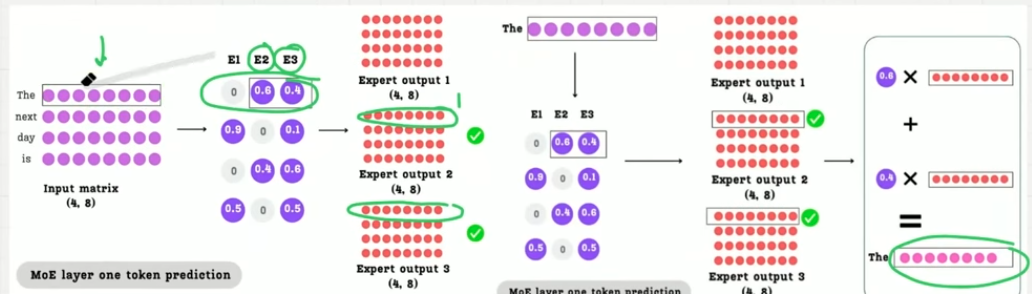

In [43]:
class SparseMoe(nn.Module):
  def __init__(self, n_embd, num_experts, topk):
      super().__init__()
      self.router = TopkRouter(n_embd, num_experts, top_k)
      self.experts = nn.ModuleList([Expert(n_embd) for _ in range(num_experts)])
      self.top_k = top_k

  def forward(self, x):
    gating_out, indices = self.router(x)
    final_out = torch.zeros_like(x)

    flat_x= x.view(-1, x.size(-1))
    flat_gating_out = gating_out.view(-1, gating_out.size(-1))

    for i, expert in enumerate(self.experts):
      expert_mask = (indices == i).any(dim=-1)
      flat_mask = expert_mask.view(-1)

      if flat_mask.any():
        expert_input = flat_x[flat_mask]
        expert_output = expert(expert_input)

        gating_scores = flat_gating_out[flat_mask, i].unsqueeze(1)
        weighed_output = expert_output * gating_scores

        final_out[expert_mask] += weighed_output.squeeze(1)

    return final_out

sparse_moe = SparseMoe(n_embd, num_experts, top_k)
final_out = sparse_moe(mh_output)
final_out

tensor([[[ 0.1770, -0.0492,  0.0057, -0.0246, -0.1241,  0.1445,  0.0890,
          -0.1697],
         [-0.3289,  0.3221,  0.1473, -0.1738,  0.0805, -0.4529,  0.0976,
          -0.2824],
         [ 0.0647, -0.0218, -0.1096, -0.0410, -0.0072,  0.0221,  0.0461,
          -0.2434],
         [ 0.0904, -0.0432, -0.0681, -0.0260, -0.0153,  0.0205,  0.0387,
          -0.1562]]], grad_fn=<IndexPutBackward0>)

# Transformers

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()
        self.norm1 = RMSNorm(cfg.hidden_size, eps=cfg.rms_norm_eps)
        self.attn = MultiheadSelfAttention(cfg)
        self.norm2 = RMSNorm(cfg.hidden_size, eps=cfg.rms_norm_eps)
        self.moe = MoE(cfg)

    def reset_parameters(self):
        # Submodules handle their own init; keep for FSDP completeness
        if hasattr(self.norm1, "reset_parameters"): self.norm1.reset_parameters()
        if hasattr(self.attn,  "reset_parameters"): self.attn.reset_parameters()
        if hasattr(self.norm2, "reset_parameters"): self.norm2.reset_parameters()
        if hasattr(self.moe,   "reset_parameters"): self.moe.reset_parameters()

    def forward(
        self,
        x: torch.Tensor,
        positions: torch.Tensor,
        causal_mask: torch.Tensor,
        is_sliding_layer: bool,
        sliding_window: int,
    ) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        a = self.attn(self.norm1(x), positions, causal_mask, is_sliding_layer, sliding_window)
        x = x + a
        m, aux = self.moe(self.norm2(x))
        x = x + m
        return x, aux

class Transformer(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()
        self.config = cfg
        H = cfg.hidden_size
        self.embed = nn.Embedding(cfg.vocab_size, H)
        self.drop = nn.Dropout(cfg.dropout)
        self.layers = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg.num_hidden_layers)])
        self.norm_f = RMSNorm(H, eps=cfg.rms_norm_eps)
        self.lm_head = nn.Linear(H, cfg.vocab_size, bias=False)

        # store init std for reset
        self.init_std = float(cfg.initializer_range)

        # optional tying
        if cfg.tie_word_embeddings:
            self.lm_head.weight = self.embed.weight

        # init once for rank0
        self.reset_parameters()

    @staticmethod
    def build_causal_mask(T: int, device, dtype=torch.bool) -> torch.Tensor:
        i = torch.arange(T, device=device)
        j = torch.arange(T, device=device)
        return (j[None, :] <= i[:, None]).to(dtype)

    def reset_parameters(self):
        init_std = getattr(self, "init_std", 0.02)
        with torch.no_grad():
            nn.init.normal_(self.embed.weight, mean=0.0, std=init_std)
            if self.lm_head.weight is not self.embed.weight:
                nn.init.normal_(self.lm_head.weight, mean=0.0, std=init_std)
        # Cascade to blocks + final norm
        for blk in getattr(self, "layers", []):
            if hasattr(blk, "reset_parameters"):
                blk.reset_parameters()
        if hasattr(self.norm_f, "reset_parameters"):
            self.norm_f.reset_parameters()

    def forward(
        self,
        input_ids: torch.Tensor,                  # (B,T)
        labels: Optional[torch.Tensor] = None,
    ) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        B, T = input_ids.shape
        device = input_ids.device
        x = self.embed(input_ids)
        x = self.drop(x)
        positions = torch.arange(T, device=device).view(1, T).expand(B, T)
        causal_mask = self.build_causal_mask(T, device)  # (T,T) bool

        aux_losses: List[torch.Tensor] = []
        for i, layer in enumerate(self.layers):
            is_sliding = (self.config.layer_types[i] == "sliding_attention")
            x, aux = layer(x, positions, causal_mask, is_sliding, self.config.sliding_window)
            if aux and "router_aux_loss" in aux:
                aux_losses.append(aux["router_aux_loss"])

        x = self.norm_f(x)
        logits = self.lm_head(x)

        loss = None
        aux_out: Dict[str, torch.Tensor] = {}
        if labels is not None:
            # next-token loss
            logits_flat = logits[:, :-1, :].contiguous().view(-1, logits.size(-1))
            targets = labels[:, 1:].contiguous().view(-1)
            nll = F.cross_entropy(logits_flat, targets, ignore_index=-100)
            if aux_losses:
                aux_total = torch.stack(aux_losses).mean()
                nll = nll + self.config.router_aux_loss_coef * aux_total
                aux_out["router_aux_loss"] = aux_total.detach()
            loss = nll
        return logits, {"loss": loss, **aux_out}


# ------------------------------------------------------------------------------------
# Quick param sanity check for the 20B config
# ------------------------------------------------------------------------------------

def gpt_oss_20b_config() -> ModelConfig:
    return ModelConfig(
        vocab_size=201_088,
        hidden_size=2880,
        num_hidden_layers=24,
        head_dim=64,
        num_attention_heads=64,
        num_key_value_heads=8,
        attention_bias=True,
        attention_dropout=0.0,
        dropout=0.0,
        max_position_embeddings=131_072,
        sliding_window=128,
        num_local_experts=32,
        experts_per_token=4,
        router_aux_loss_coef=0.02,
        intermediate_size=2880,
        swiglu_clip=7.0,
        rope_theta=150_000.0,
        enable_sink_logit=True,   # sink-bias enabled (flash kept on full-attn layers)
        sink_logit_init=4.0,
        rms_norm_eps=1e-5,
        initializer_range=0.02,
        tie_word_embeddings=False,
        eos_token_id=None,
    )


if __name__ == "__main__":
    cfg = gpt_oss_20b_config()
    model = Transformer(cfg)
    n_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {n_params/1e9:.3f} B")
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable:        {trainable/1e9:.3f} B")

NameError: name 'nn' is not defined